<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Tuning

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [ ]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 2.7MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774790 sha256=a251125d1bef21b93aa141636e0f08a552b4880816dbdfbdc756d7c1aa73d7e7
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=af970fa2b5d5c98a2ee1a2eda02f077246c20b8b16cbcc07f0f9531b96a49c98
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 19.8MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119247 sha256=fffa5

## Custom Functions

In [ ]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True,rmse=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=1

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,150,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    # Root mean squared error
    if rmse:
      from pysurvival.utils.display import compare_to_actual

      rmse_result = compare_to_actual(model, X_test, T_test, E_test,
                                  is_at_risk = False,  figure_size=(16, 6),
                                  metrics = ['rmse'])


    #return results
    results = pd.DataFrame({'c_index':[c_index],
                            'ibs':[ibs],
                            'mean_auc':[mean_auc],
                            'rmse':[rmse_result['root_mean_squared_error']]})
    return results

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

store_id  time  event  ... seller_probability        tx   gmv_usd
0  1842269723731683560   261      1  ...           1.014303 -0.042809 -0.071061
1  4773050910207726165   107      1  ...          -0.214408 -0.076793 -0.092084
2  4171477716070775996   102      0  ...          -0.467481  0.602888  0.209250
3  -558102186785033374   101      1  ...          -0.574383 -0.110777 -0.106463
4 -2987486431769169084   444      0  ...           1.614260 -0.099449 -0.103126

[5 rows x 12 columns]

## Create Train, Test and Eval datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA
data_statistics = raw_data.describe()

## Remove negative time
raw_data = raw_data[raw_data['time']>=0]

for feature in ['products_created','admin_visits','tx','gmv_usd']:

  # Remove data with the quantiles method
  q1 = data_statistics[feature]['25%']
  q3 = data_statistics[feature]['75%']
  iqr = q3 - q1
  raw_data = raw_data[~((raw_data[feature] < (q1 - 1.5 * iqr)) | (raw_data[feature] > (q3 + 1.5 * iqr))) ]

  # Remove data with the std method
  raw_data = raw_data[raw_data[feature] <= (data_statistics[feature]['mean'] + 3 * data_statistics[feature]['std'])]

## Remove tx feature
raw_data.drop(['tx'], axis=1, inplace=True)

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Model optimization: Random Survival Forest 


FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:5
c-index: 0.6954


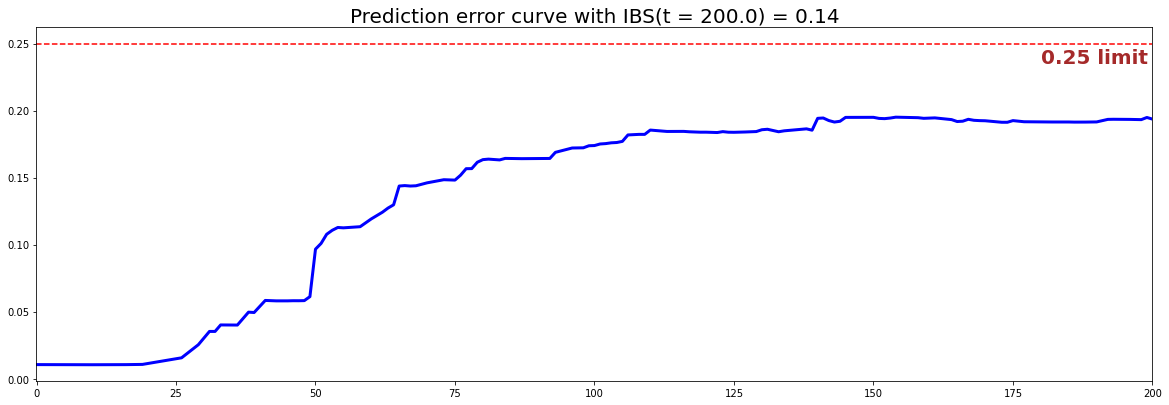

IBS: 0.1382
AUC: 0.7702


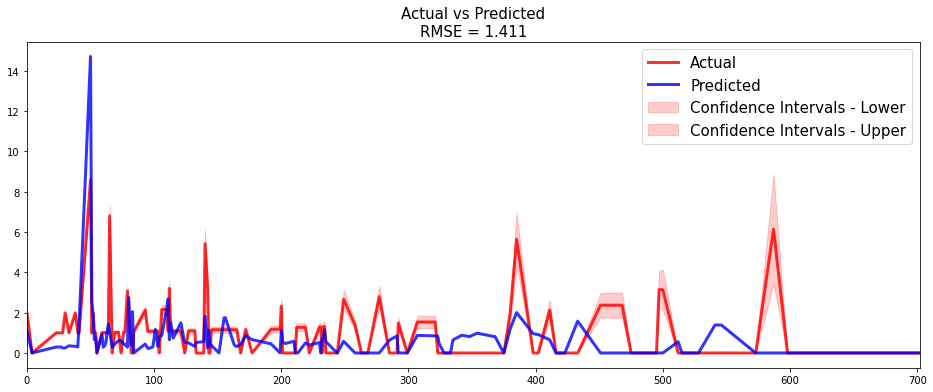

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:10
c-index: 0.7033


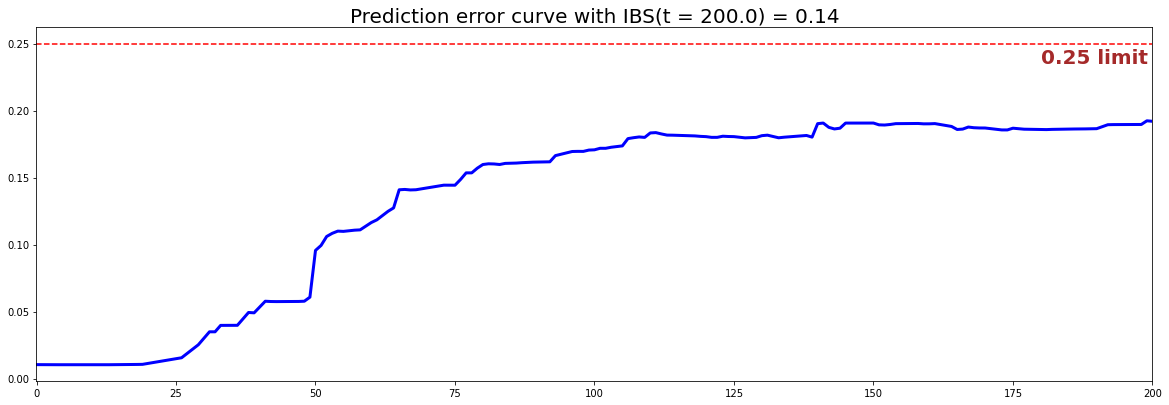

IBS: 0.1353
AUC: 0.7784


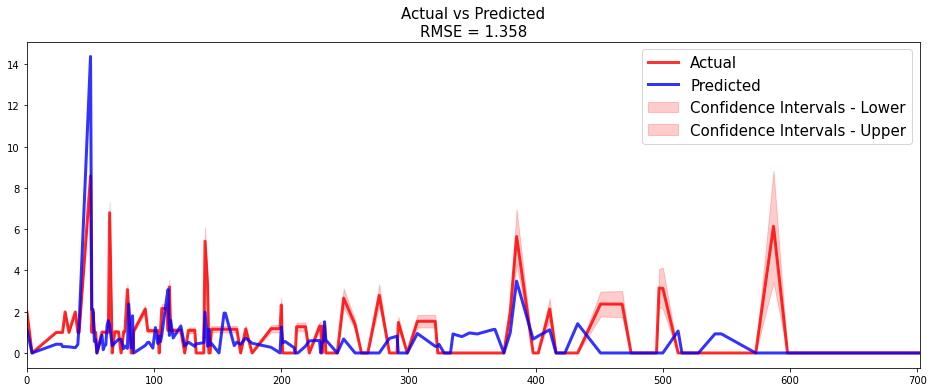

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth5 - min_node_size:20
c-index: 0.6806


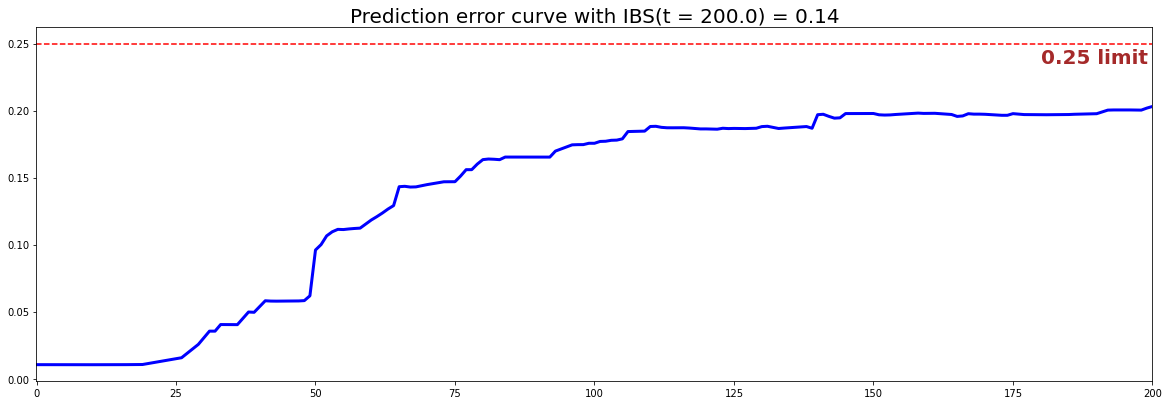

IBS: 0.1400
AUC: 0.7482


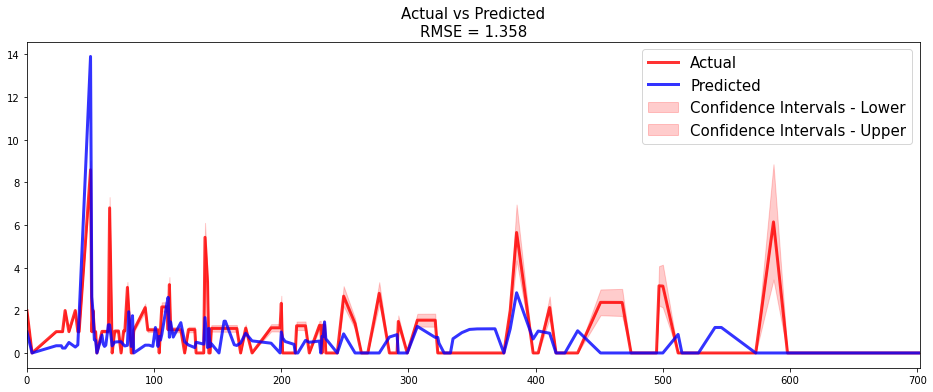

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:5
c-index: 0.6900


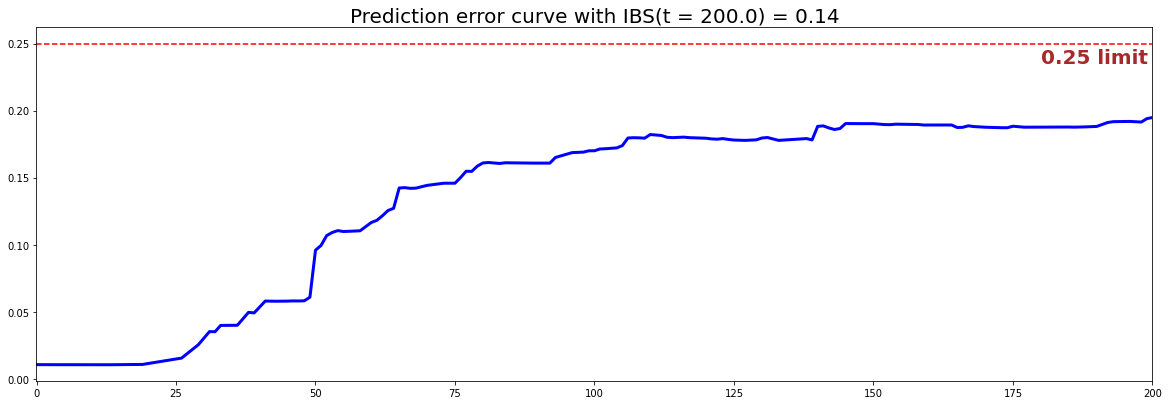

IBS: 0.1354
AUC: 0.7648


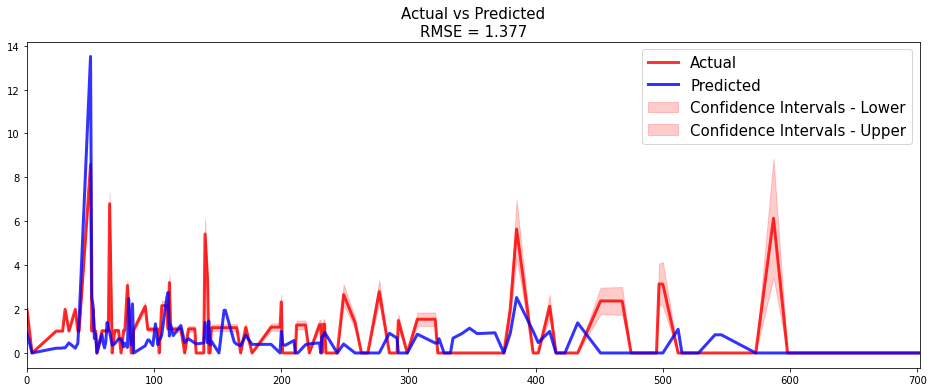

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:10
c-index: 0.6948


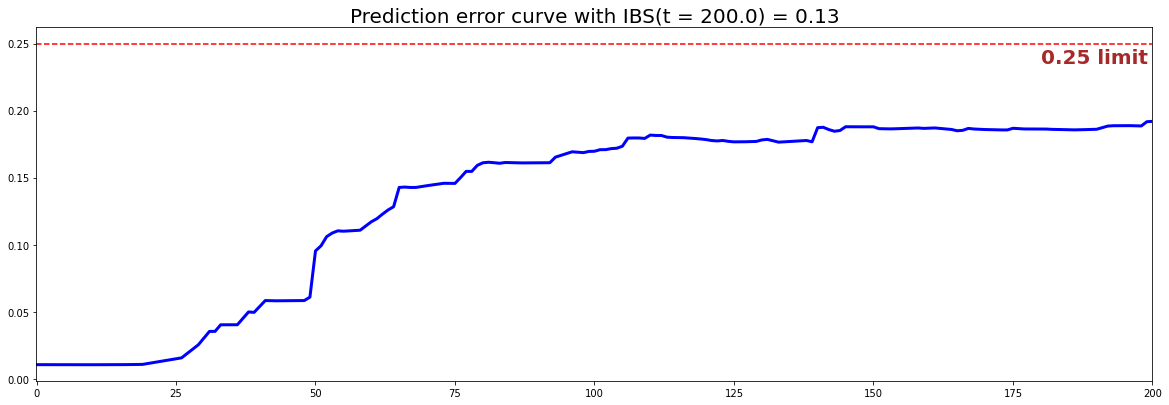

IBS: 0.1346
AUC: 0.7756


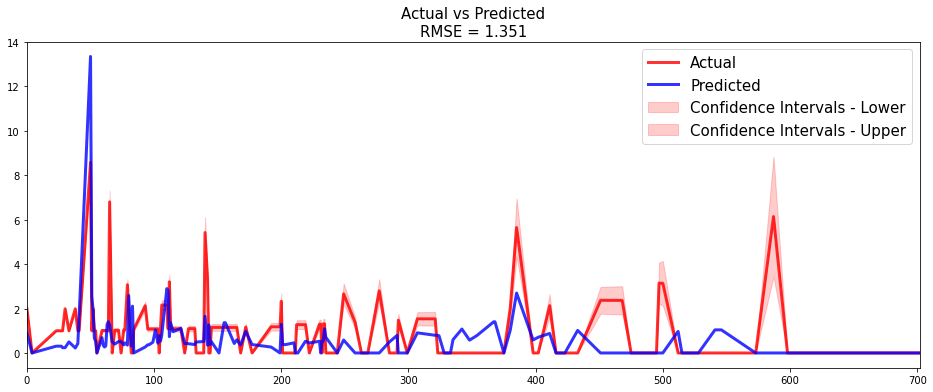

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth10 - min_node_size:20
c-index: 0.7034


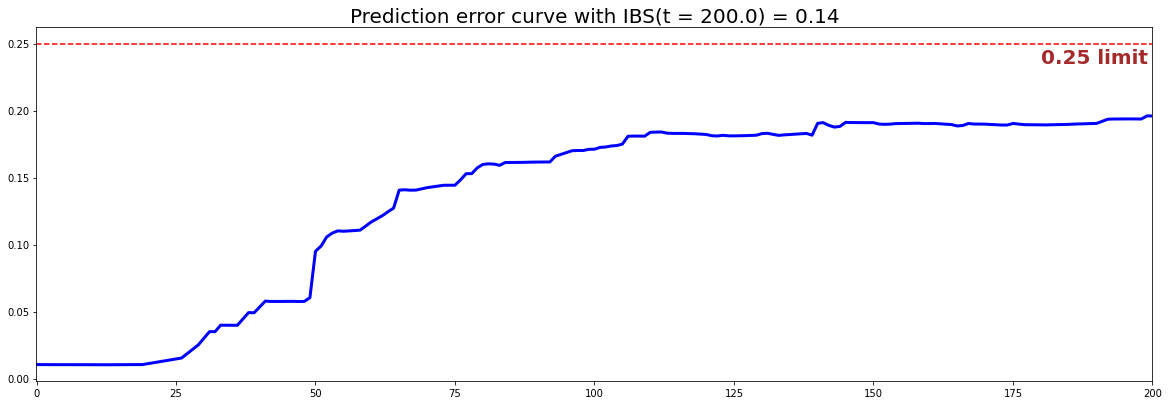

IBS: 0.1362
AUC: 0.7736


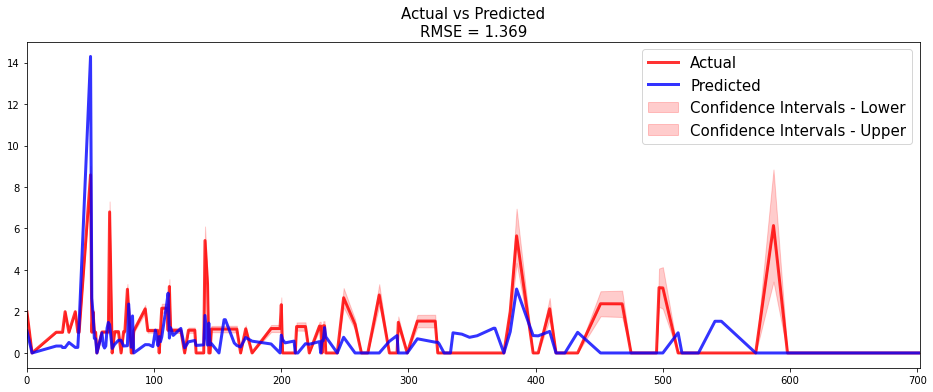

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:5
c-index: 0.6972


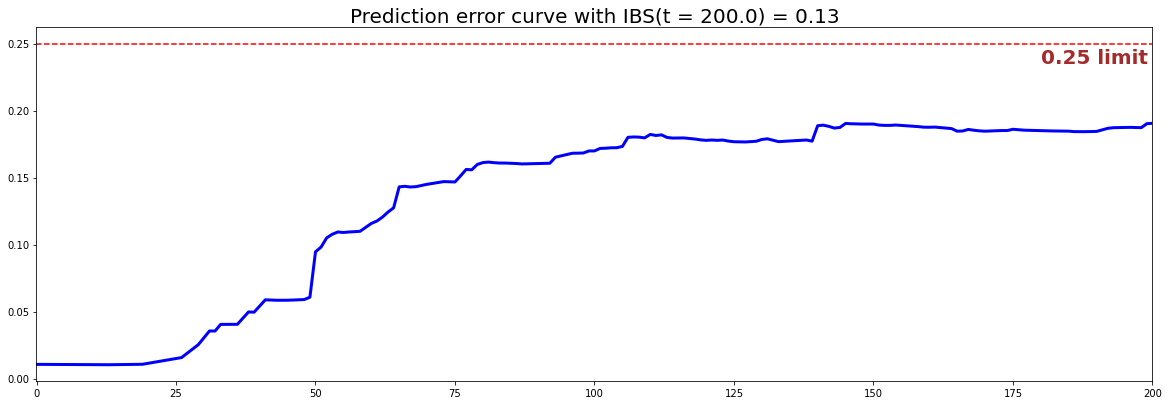

IBS: 0.1346
AUC: 0.7751


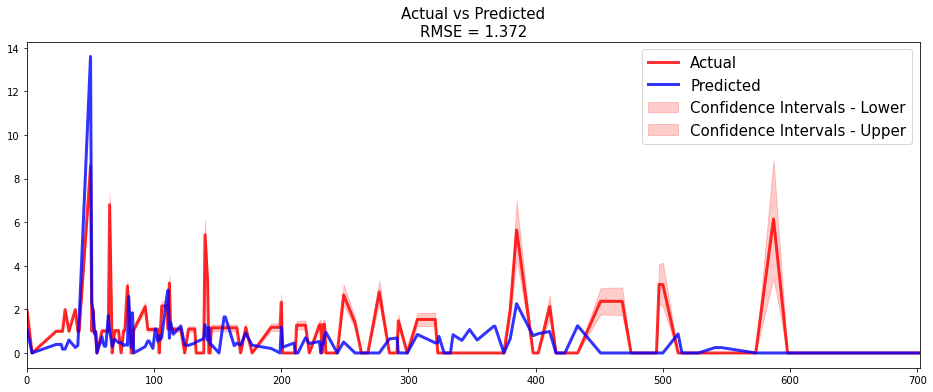

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:10
c-index: 0.6930


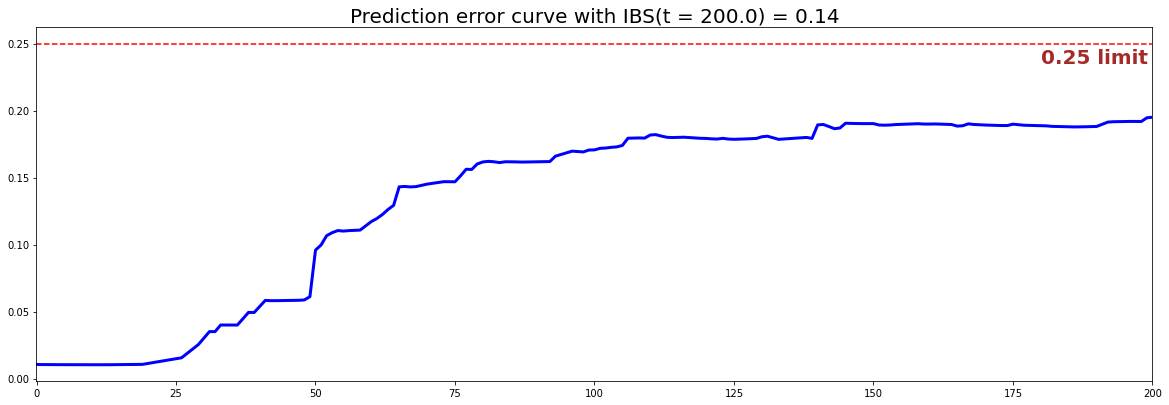

IBS: 0.1358
AUC: 0.7690


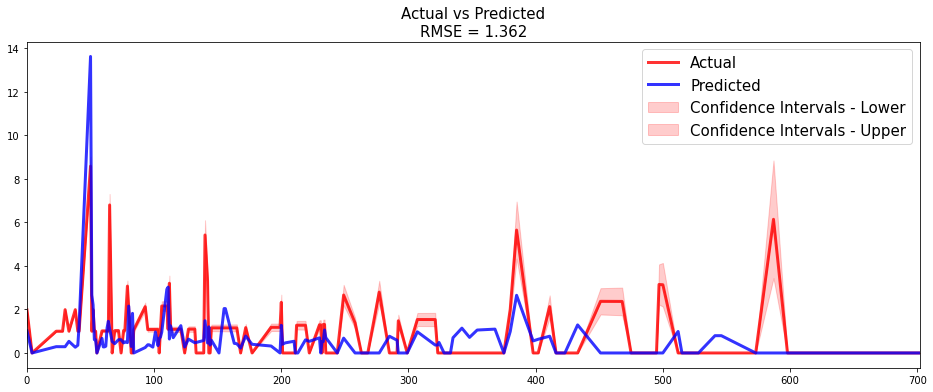

FIT MODEL WITH PARAMETERS
num_trees:50 - max_depth20 - min_node_size:20
c-index: 0.6895


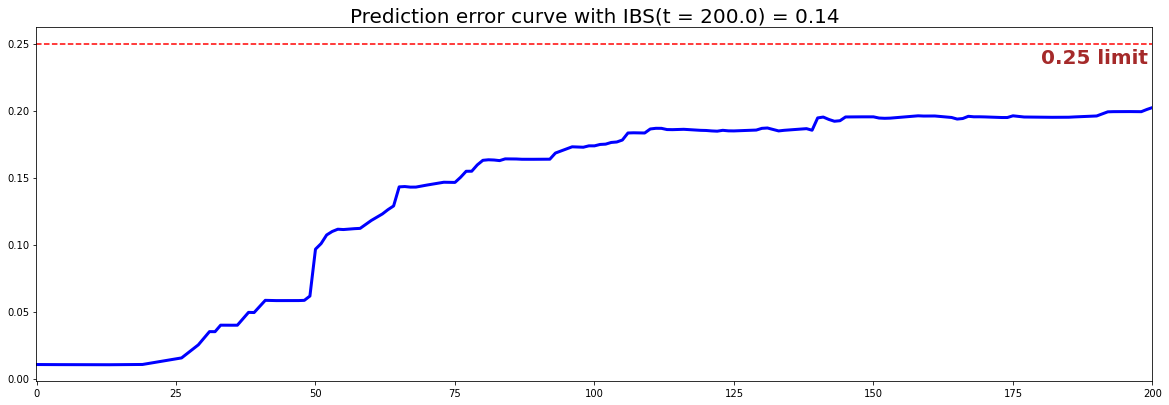

IBS: 0.1390
AUC: 0.7621


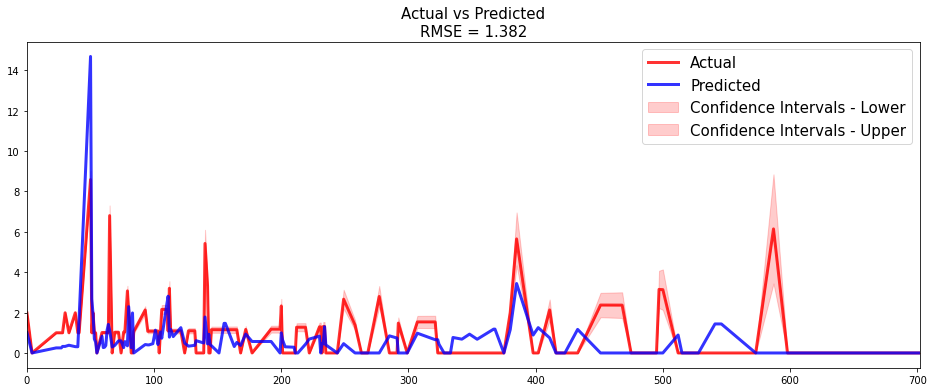

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:5
c-index: 0.7057


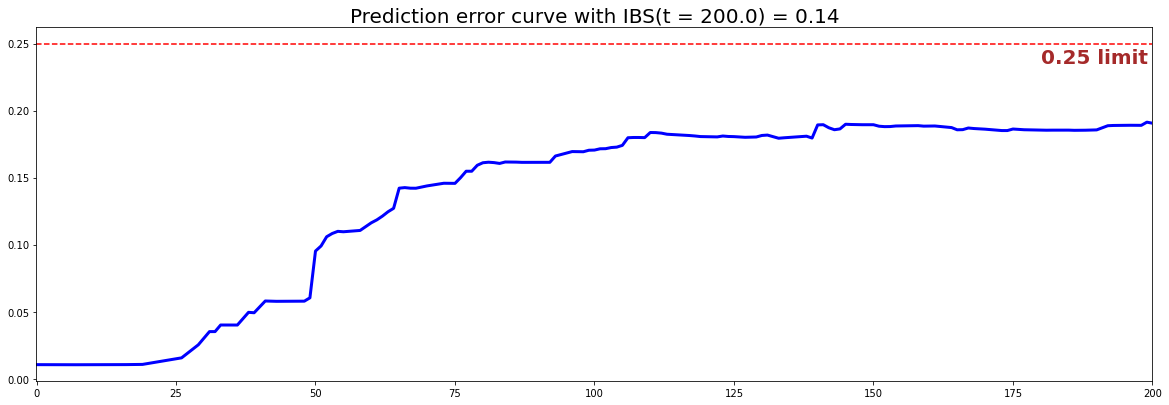

IBS: 0.1351
AUC: 0.7819


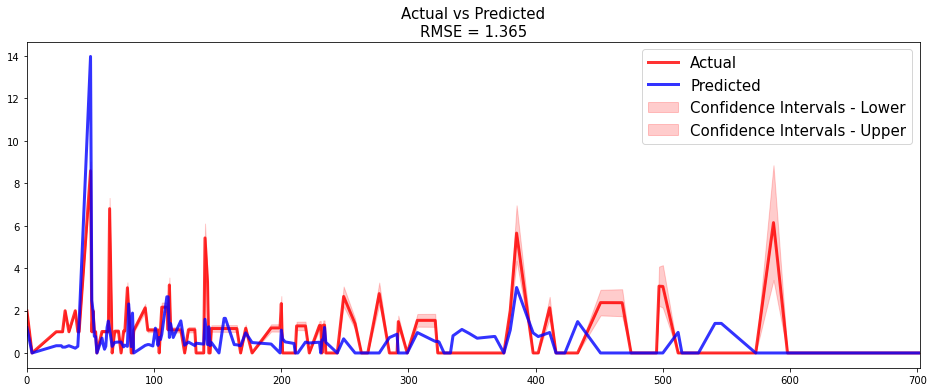

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:10
c-index: 0.6998


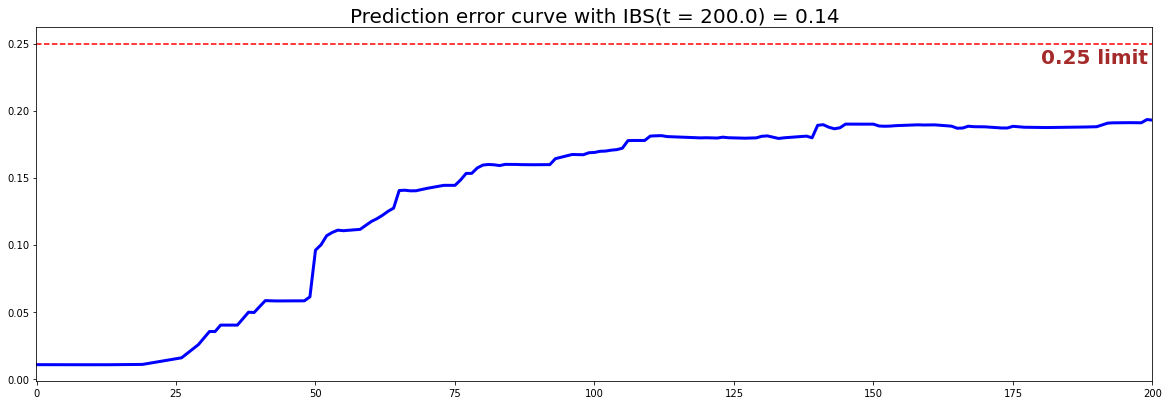

IBS: 0.1351
AUC: 0.7761


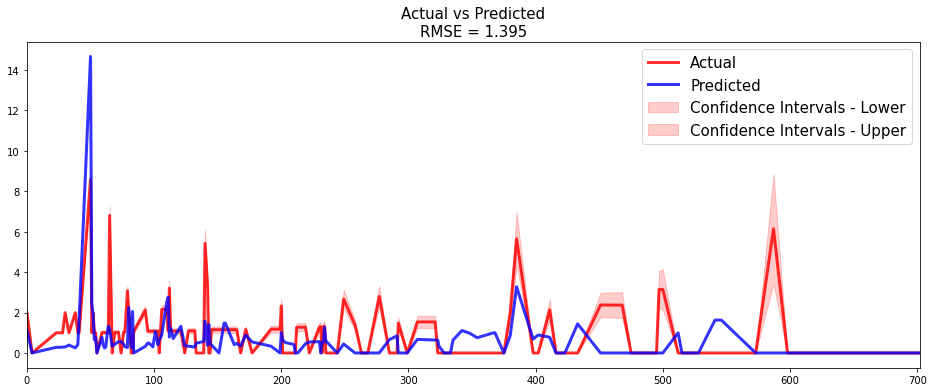

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth5 - min_node_size:20
c-index: 0.6974


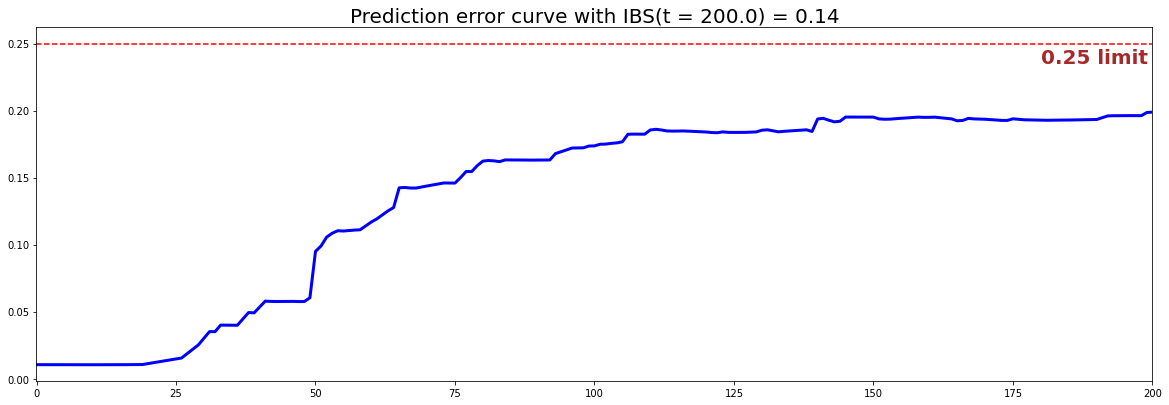

IBS: 0.1381
AUC: 0.7670


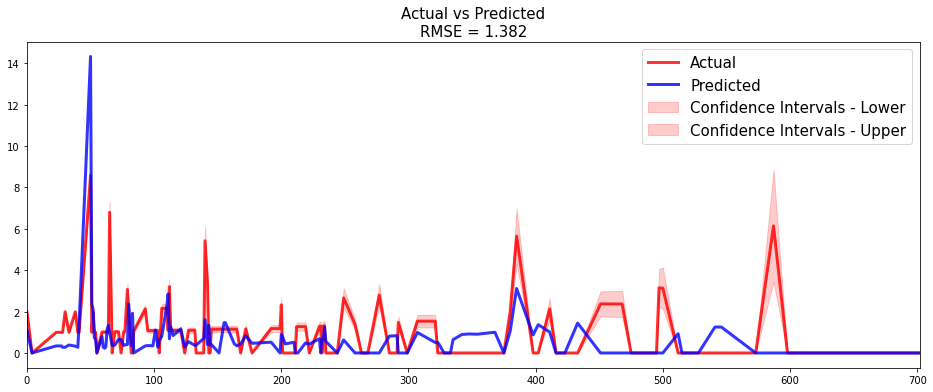

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:5
c-index: 0.6999


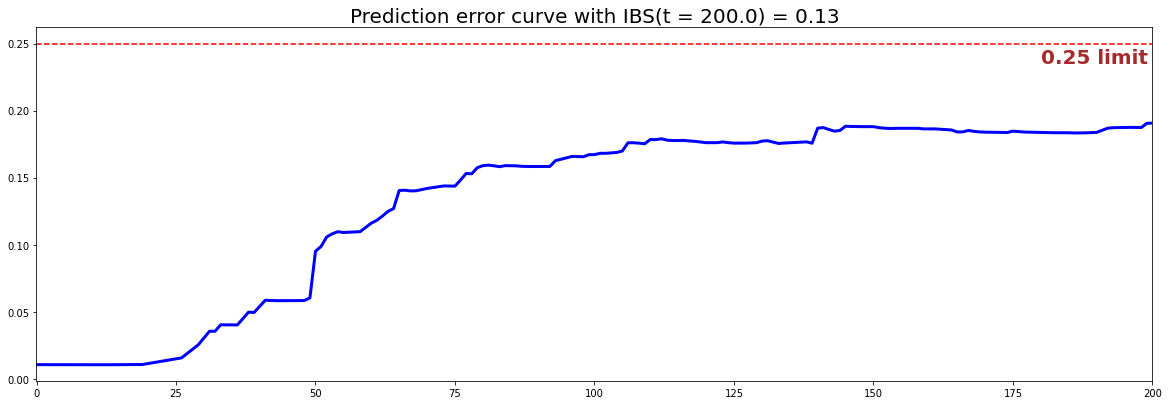

IBS: 0.1334
AUC: 0.7775


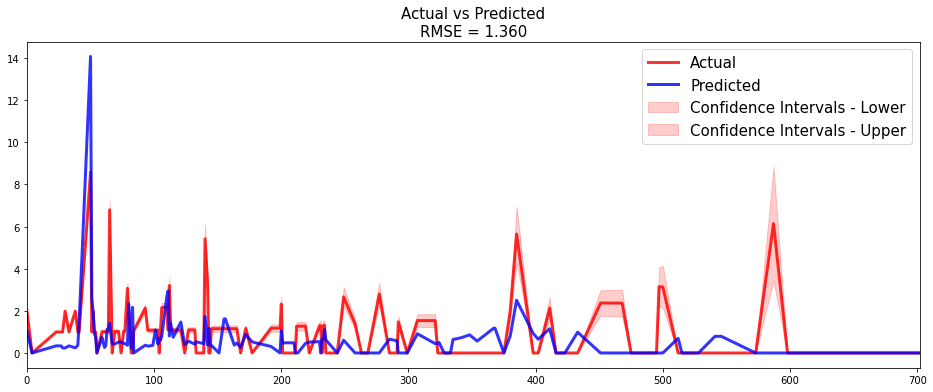

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:10
c-index: 0.7024


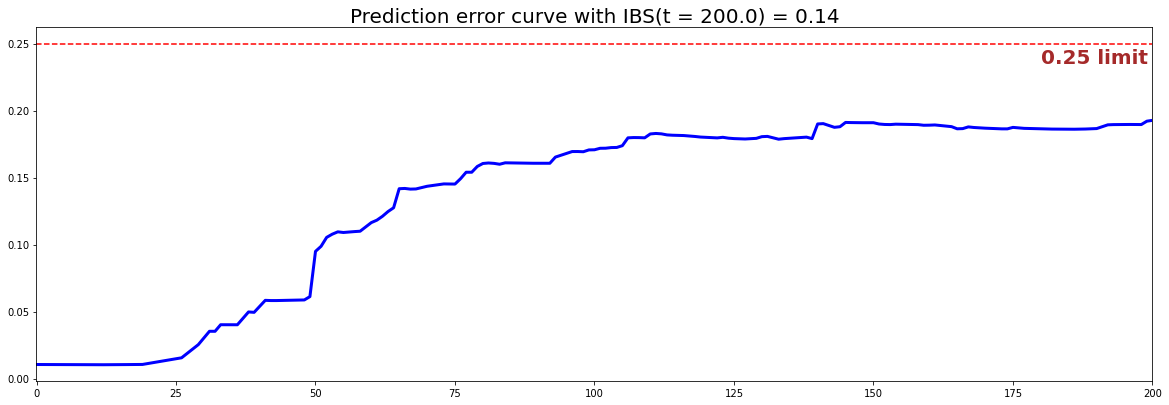

IBS: 0.1352
AUC: 0.7773


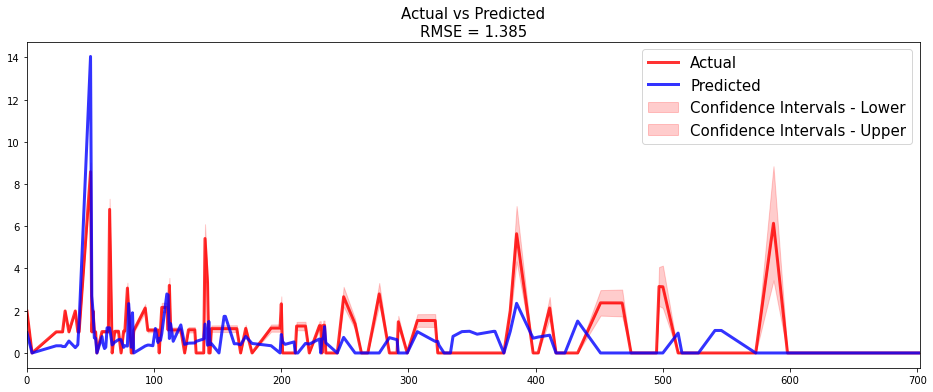

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth10 - min_node_size:20
c-index: 0.6963


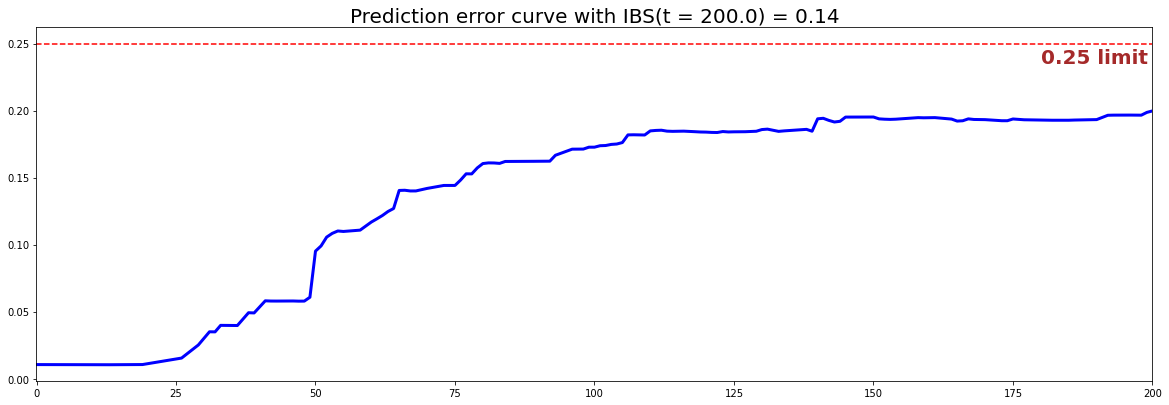

IBS: 0.1378
AUC: 0.7671


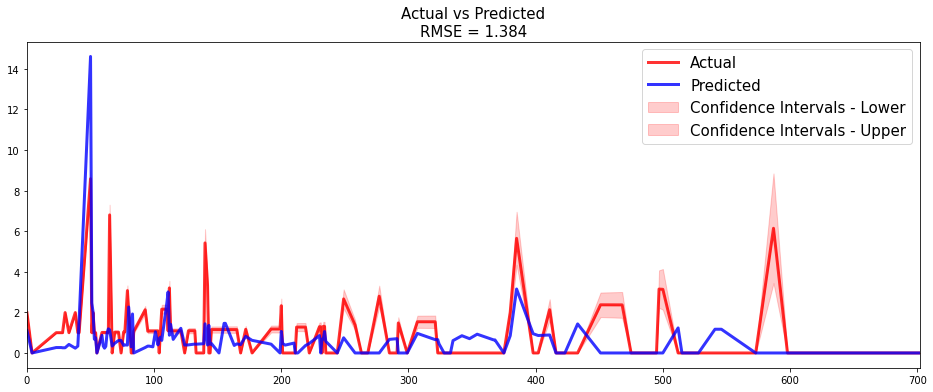

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:5
c-index: 0.6967


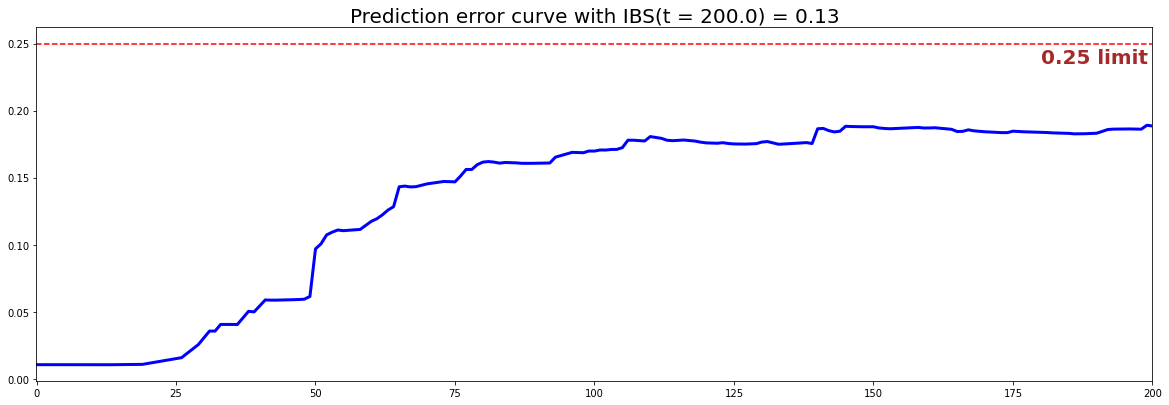

IBS: 0.1341
AUC: 0.7746


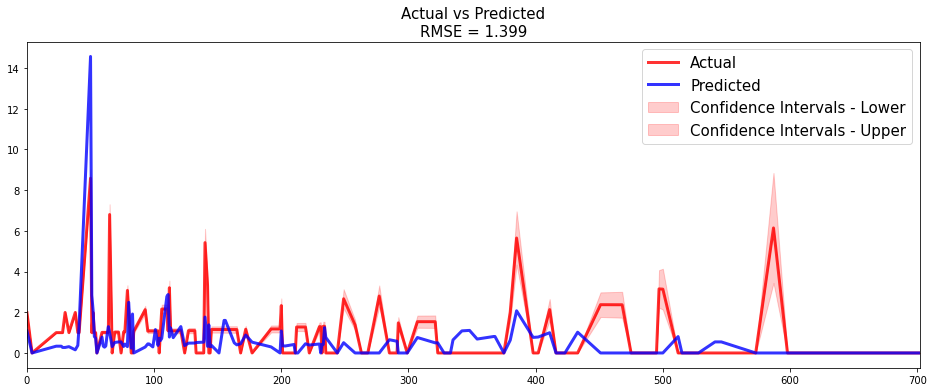

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:10
c-index: 0.6963


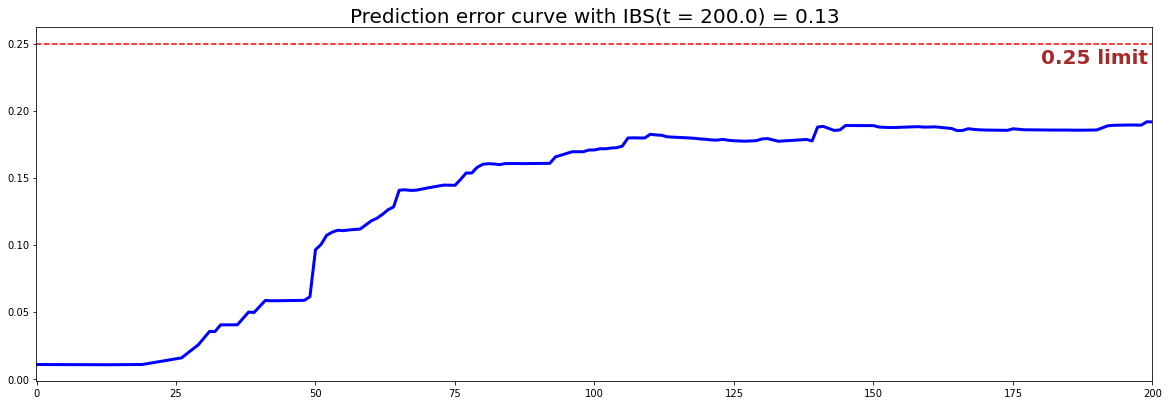

IBS: 0.1346
AUC: 0.7733


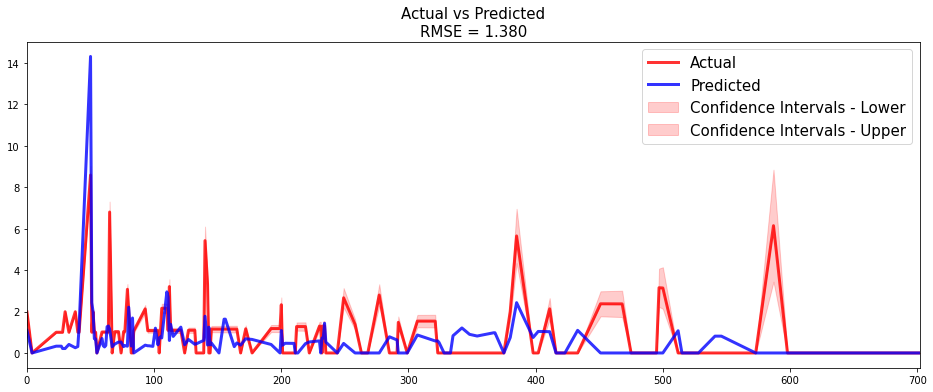

FIT MODEL WITH PARAMETERS
num_trees:100 - max_depth20 - min_node_size:20
c-index: 0.6938


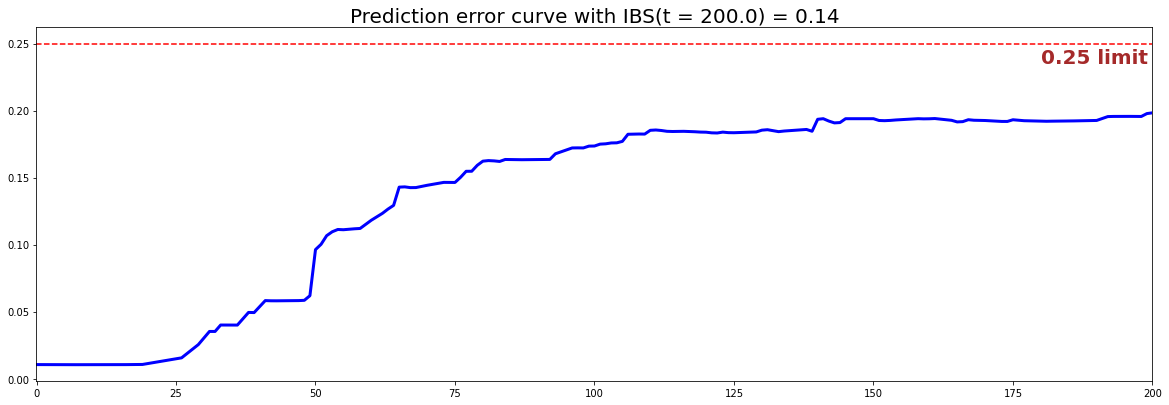

IBS: 0.1380
AUC: 0.7658


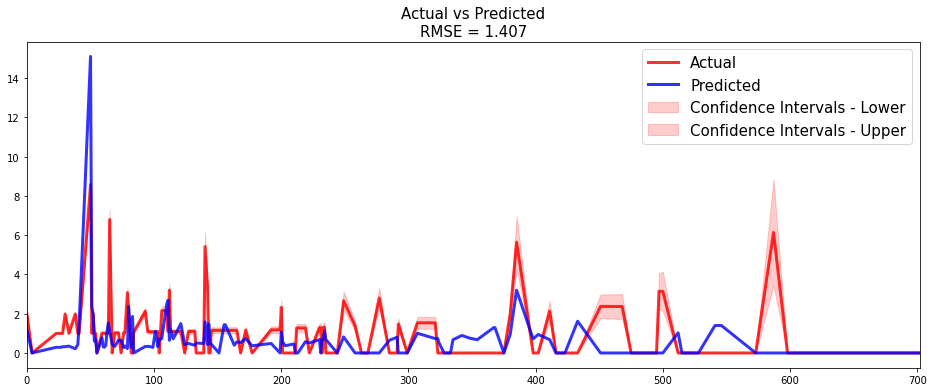

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:5
c-index: 0.7016


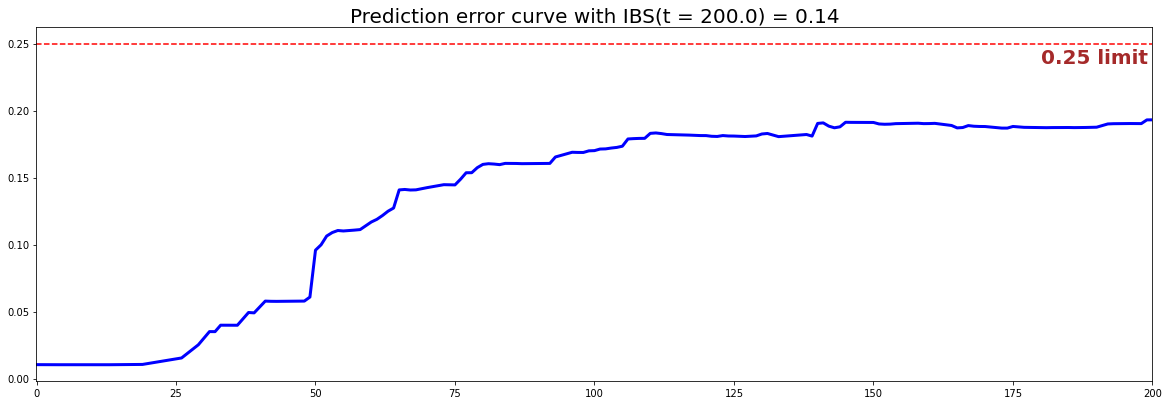

IBS: 0.1356
AUC: 0.7763


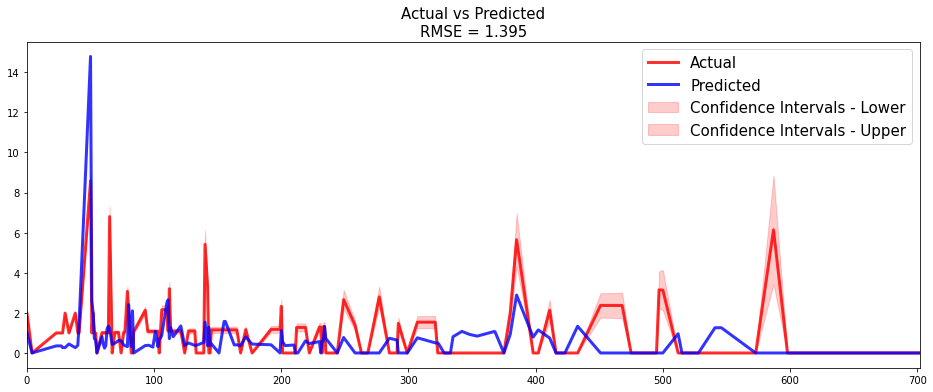

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:10
c-index: 0.7004


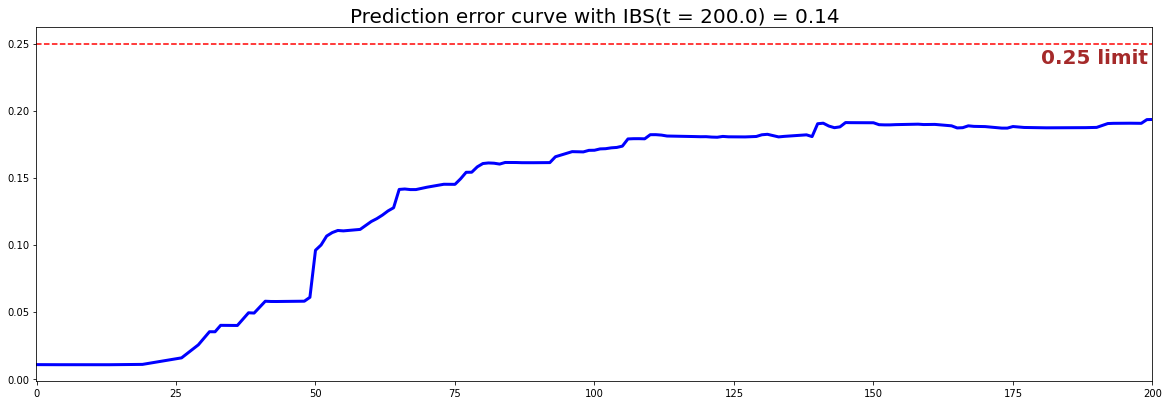

IBS: 0.1355
AUC: 0.7743


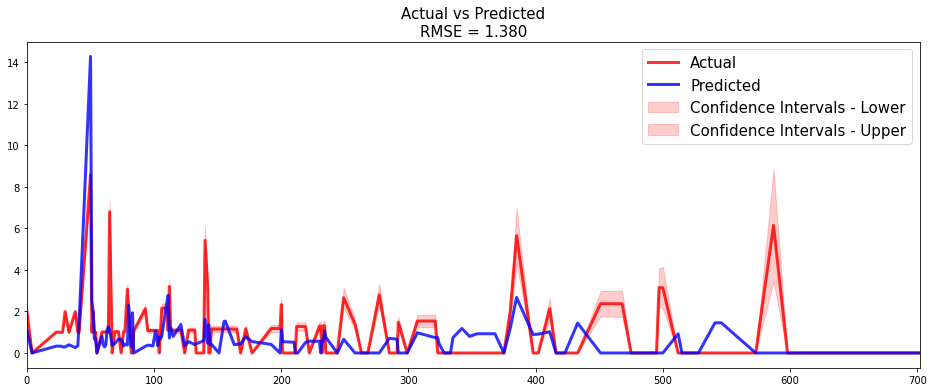

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth5 - min_node_size:20
c-index: 0.6926


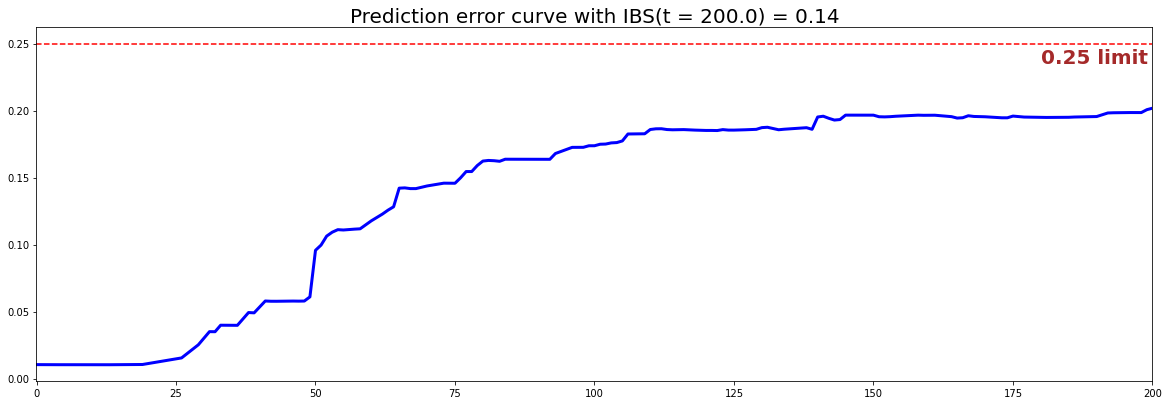

IBS: 0.1389
AUC: 0.7648


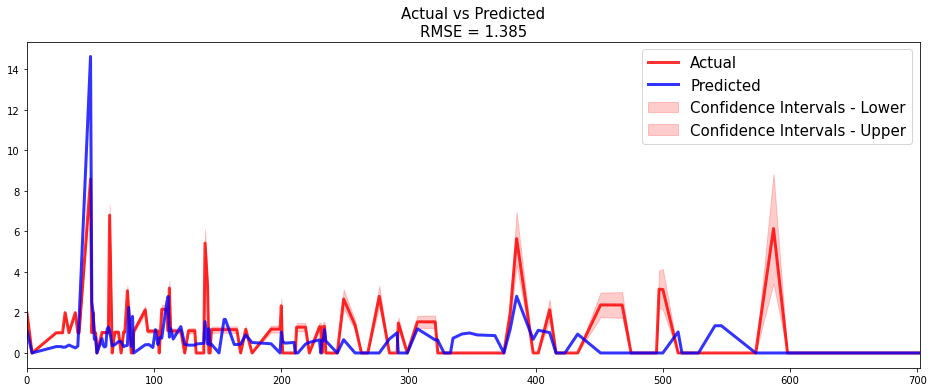

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:5
c-index: 0.6979


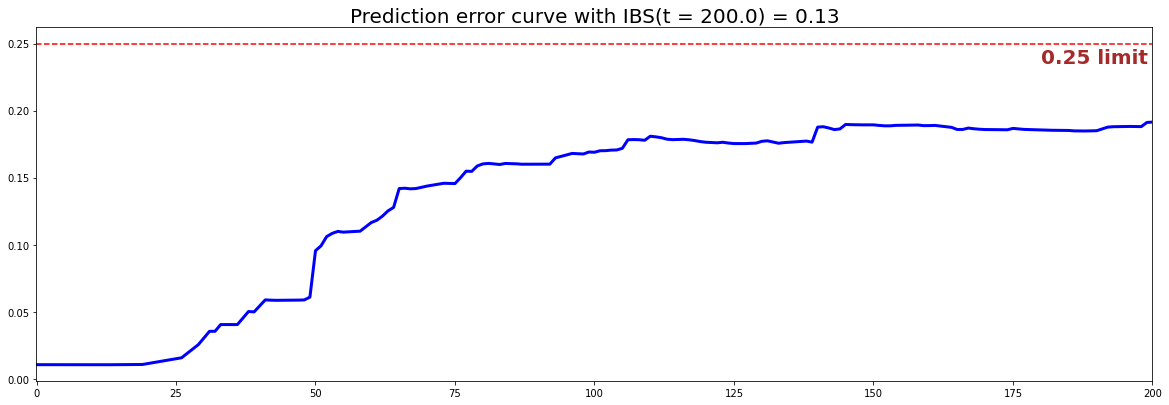

IBS: 0.1344
AUC: 0.7766


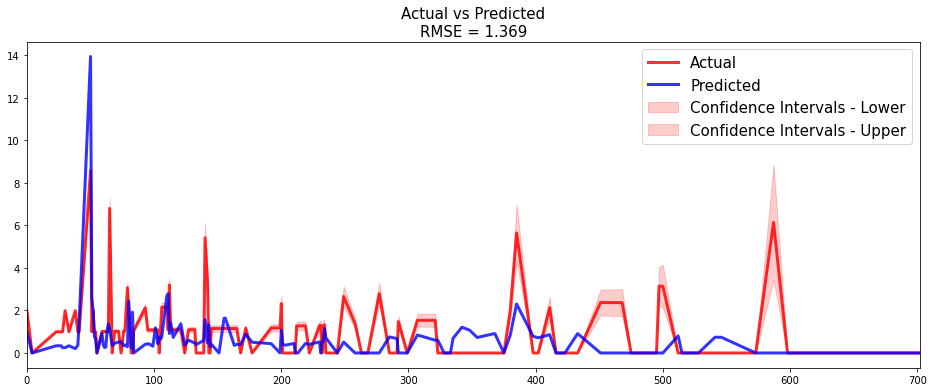

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:10
c-index: 0.7016


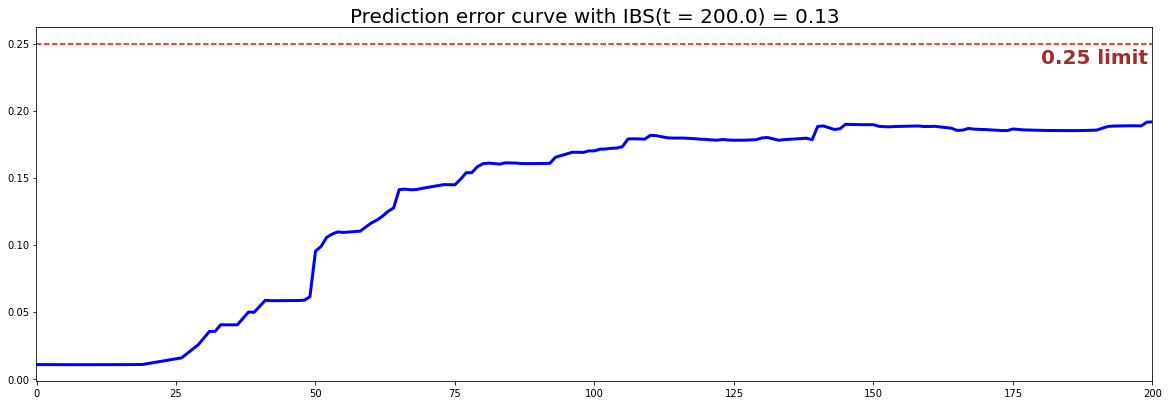

IBS: 0.1346
AUC: 0.7815


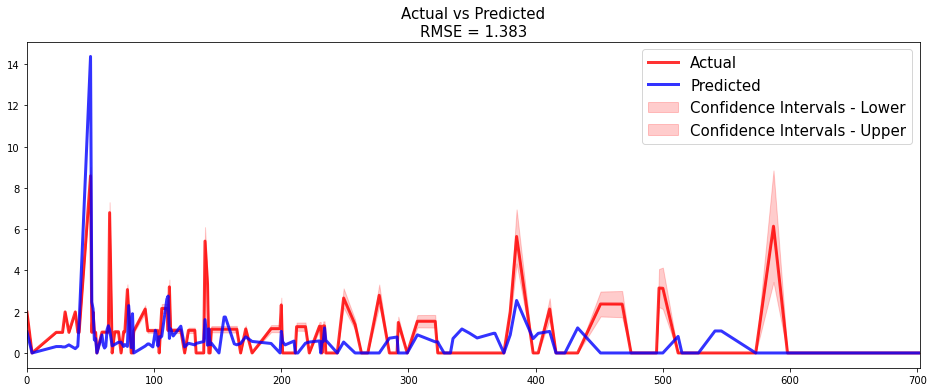

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth10 - min_node_size:20
c-index: 0.6993


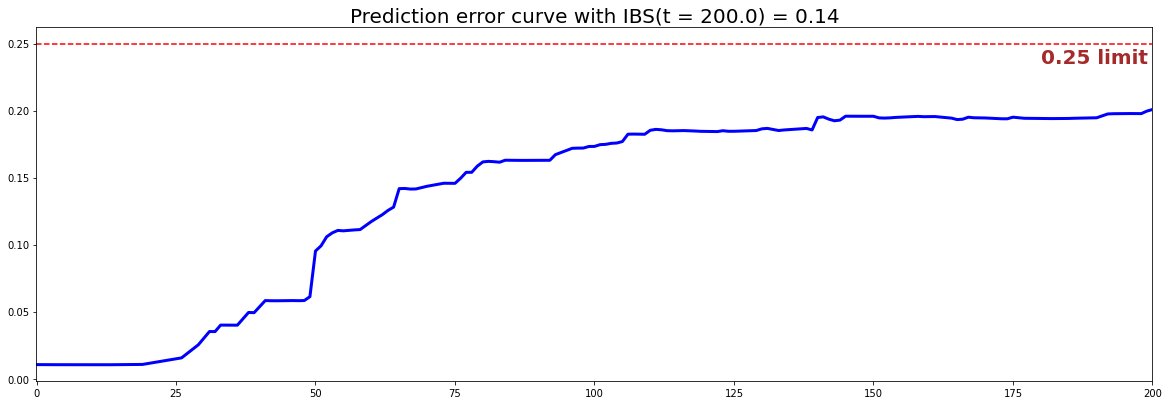

IBS: 0.1385
AUC: 0.7706


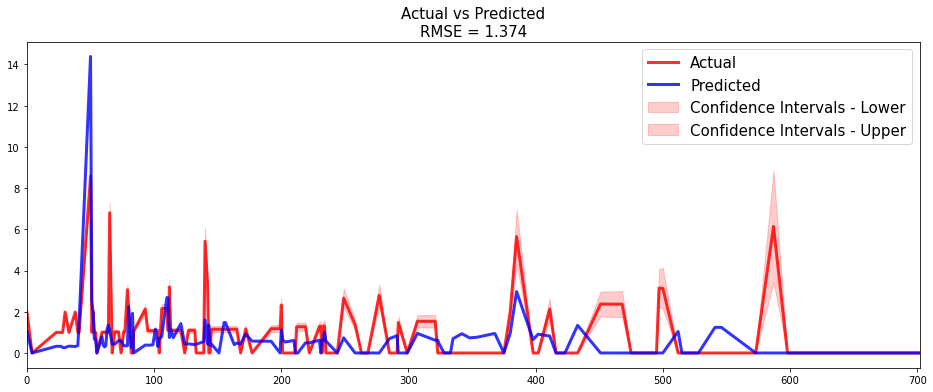

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:5
c-index: 0.7005


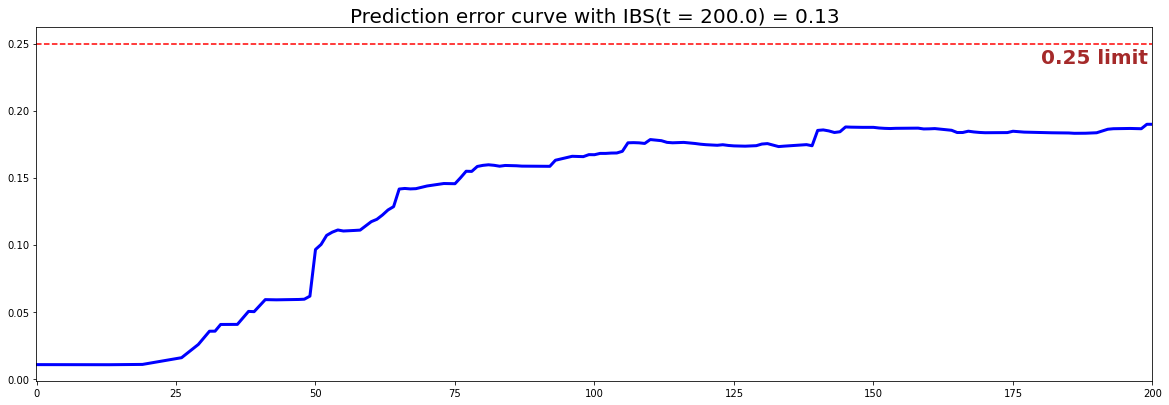

IBS: 0.1333
AUC: 0.7802


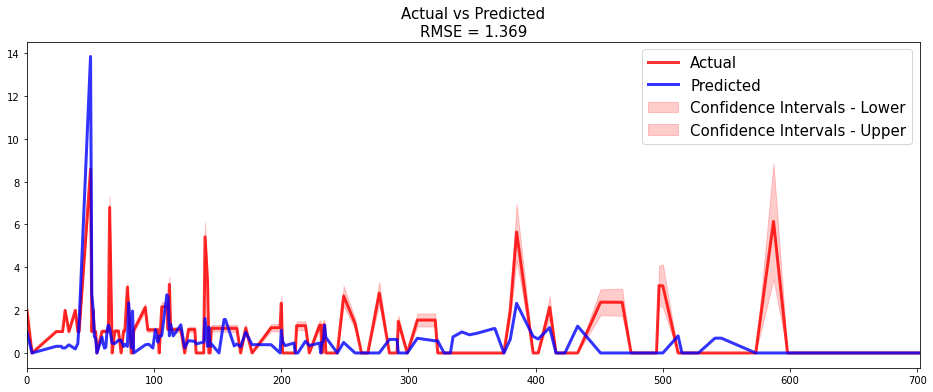

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:10
c-index: 0.6975


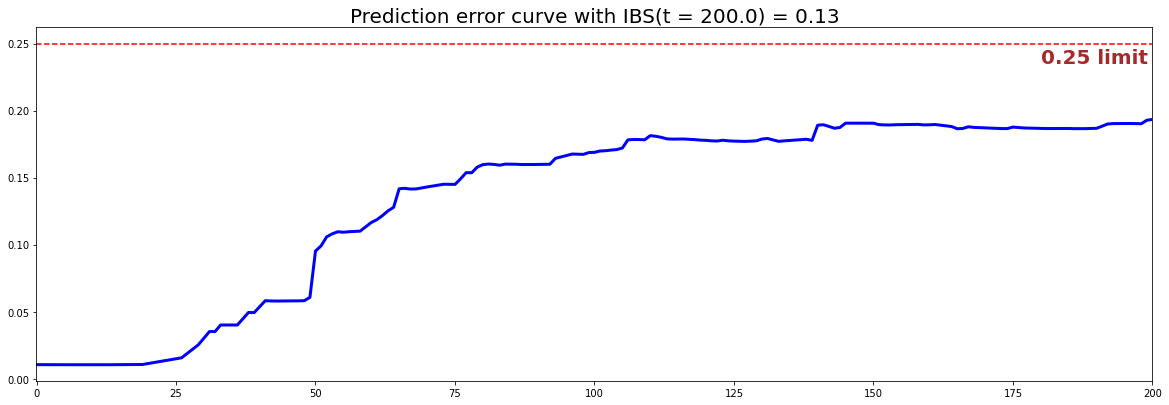

IBS: 0.1348
AUC: 0.7725


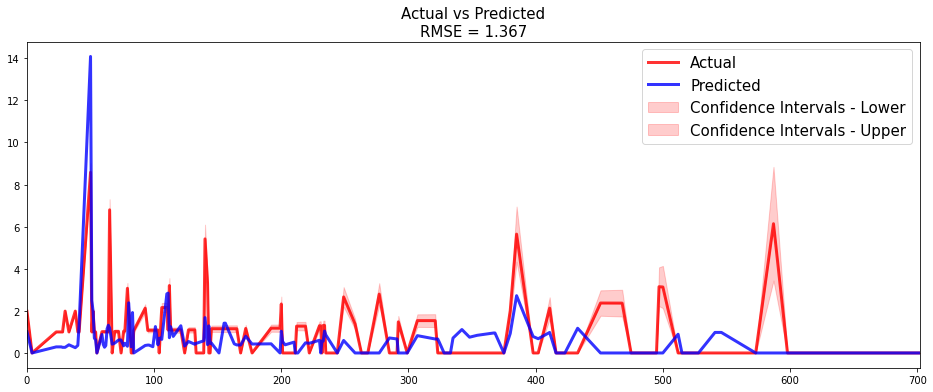

FIT MODEL WITH PARAMETERS
num_trees:200 - max_depth20 - min_node_size:20
c-index: 0.6940


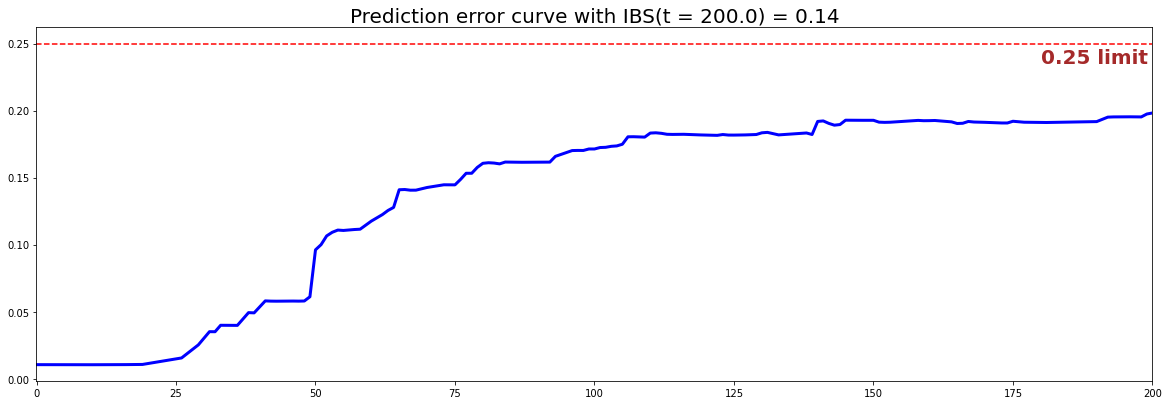

IBS: 0.1368
AUC: 0.7690


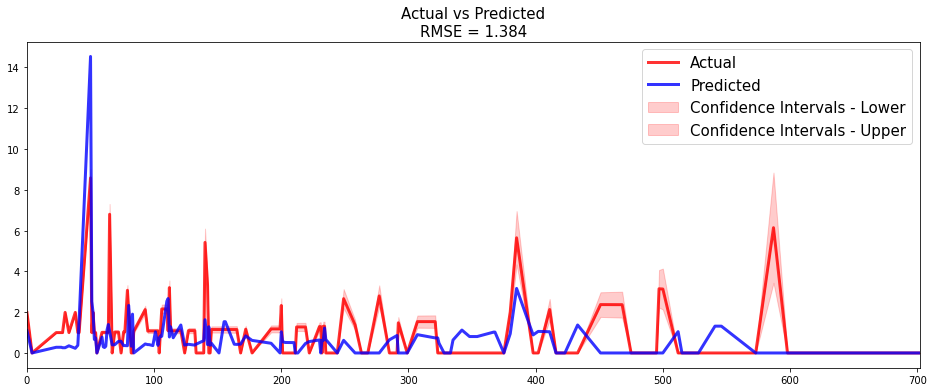

In [ ]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd
import numpy as np

# Create empty dataframe for storing the results
results_rsf = pd.DataFrame()

# Test num_trees
for num_trees in [50,100,200]:
  for max_depth in [5,10,20]:
    for min_node_size in [5,10,20]:
           
      print('FIT MODEL WITH PARAMETERS')
      print('num_trees:{} - max_depth{} - min_node_size:{}'.format(num_trees,max_depth,min_node_size))

      ## Build the model
      rsf = RandomSurvivalForestModel(num_trees=num_trees)
      rsf.fit(X_train, T_train, E_train,
              max_features="sqrt", max_depth=max_depth, min_node_size=min_node_size)

      ## Evaluate model
      tmp_results_rsf = evaluate_model(rsf,X_train,T_train,E_train,X_test,T_test,E_test)
      tmp_results_rsf['num_trees'] = [num_trees]
      tmp_results_rsf['max_depth'] = [max_depth]
      tmp_results_rsf['min_node_size'] = [min_node_size]        
      results_rsf = pd.concat([results_rsf, tmp_results_rsf], ignore_index=True)

In [ ]:
results_rsf.round(4).head(100)

c_index     ibs  mean_auc    rmse  num_trees  max_depth  min_node_size
0    0.6954  0.1382    0.7702  1.4112         50          5              5
1    0.7033  0.1353    0.7784  1.3582         50          5             10
2    0.6806  0.1400    0.7482  1.3584         50          5             20
3    0.6900  0.1354    0.7648  1.3770         50         10              5
4    0.6948  0.1346    0.7756  1.3513         50         10             10
5    0.7034  0.1362    0.7736  1.3693         50         10             20
6    0.6972  0.1346    0.7751  1.3715         50         20              5
7    0.6930  0.1358    0.7690  1.3617         50         20             10
8    0.6895  0.1390    0.7621  1.3822         50         20             20
9    0.7057  0.1351    0.7819  1.3654        100          5              5
10   0.6998  0.1351    0.7761  1.3953        100          5             10
11   0.6974  0.1381    0.7670  1.3818        100          5             20
12   0.6999  0.1334    0.7775  1.3596        100         10              5
13   0.7024  0.1352    0.7773  1.3849        100         10             10
14   0.6963  0.1378    0.7671  1.3837        100         10             20
15   0.6967  0.1341    0.7746  1.3991        100         20              5
16   0.6963  0.1346    0.7733  1.3795        100         20             10
17   0.6938  0.1380    0.7658  1.4065        100         20             20
18   0.7016  0.1356    0.7763  1.3946        200          5              5
19   0.7004  0.1355    0.7743  1.3798        200          5             10
20   0.6926  0.1389    0.7648  1.3853        200          5             20
21   0.6979  0.1344    0.7766  1.3692        200         10              5
22   0.7016  0.1346    0.7815  1.3829        200         10             10
23   0.6993  0.1385    0.7706  1.3741        200         10             20
24   0.7005  0.1333    0.7802  1.3695        200         20              5
25   0.6975  0.1348    0.7725  1.3670        200         20             10
26   0.6940  0.1368    0.7690  1.3835        200         20             20

In [ ]:
print('max c_index is on line:{}'.format(results_rsf['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results_rsf['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results_rsf['ibs'].idxmin()))
print('min rmse is on line:{}'.format(results_rsf['rmse'].idxmin()))

max c_index is on line:9
max mean_auc is on line:9
min ibs is on line:24
min rmse is on line:4


## Model Optimizacion: Cox Proportional Hazard

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.0001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


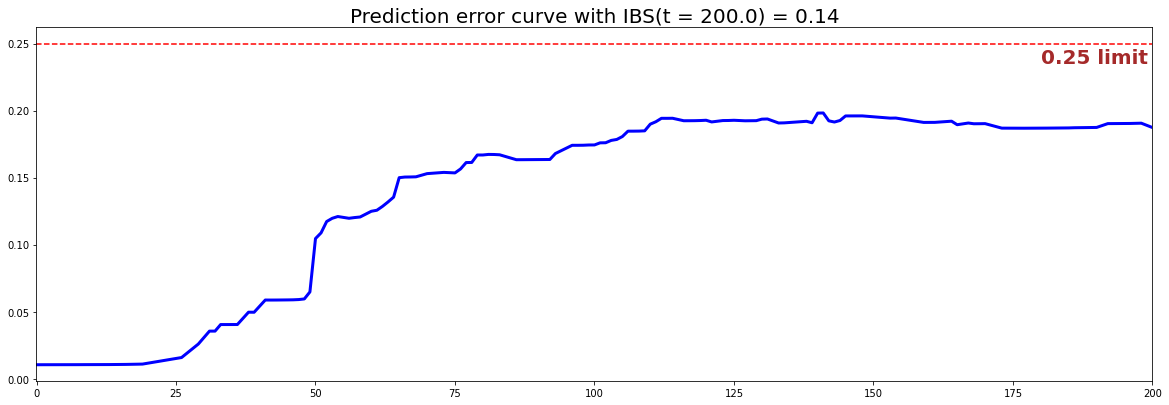

IBS: 0.1399
AUC: 0.7766


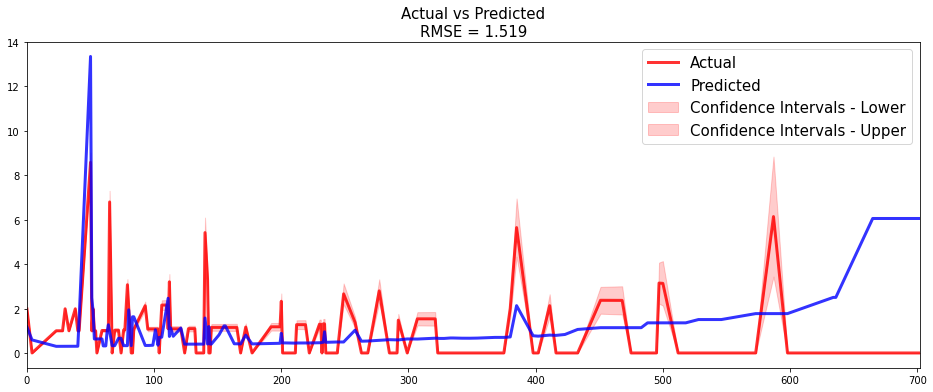

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.0001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


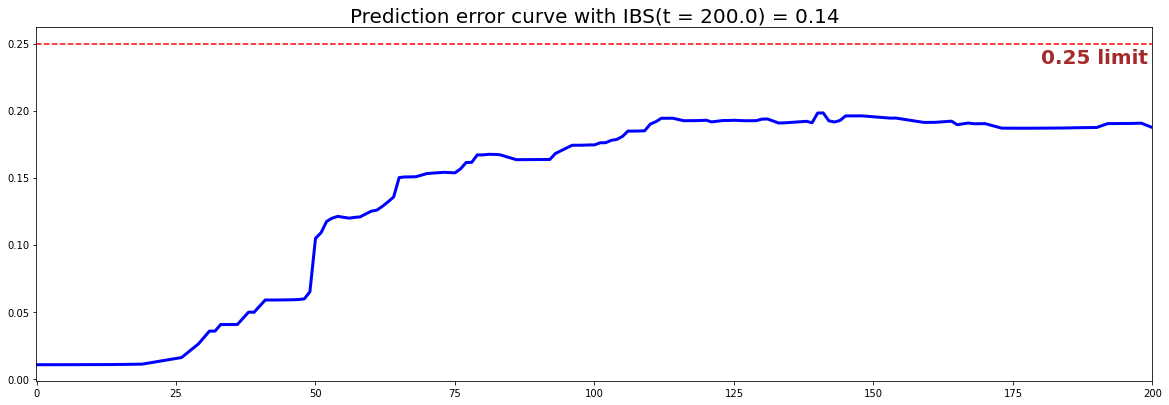

IBS: 0.1399
AUC: 0.7768


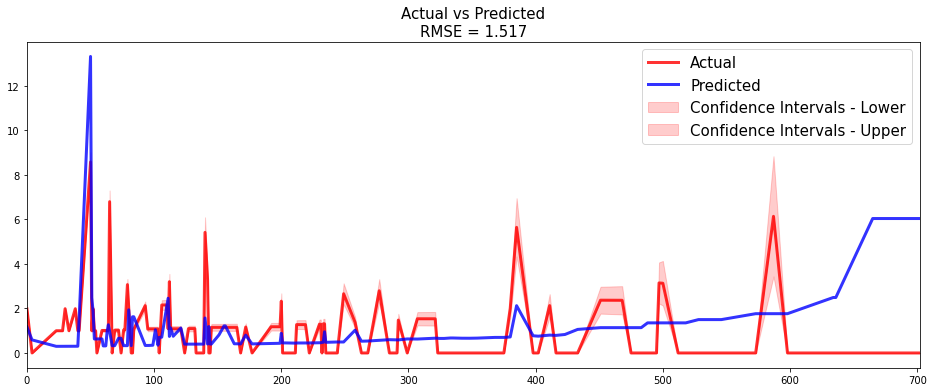

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.0001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


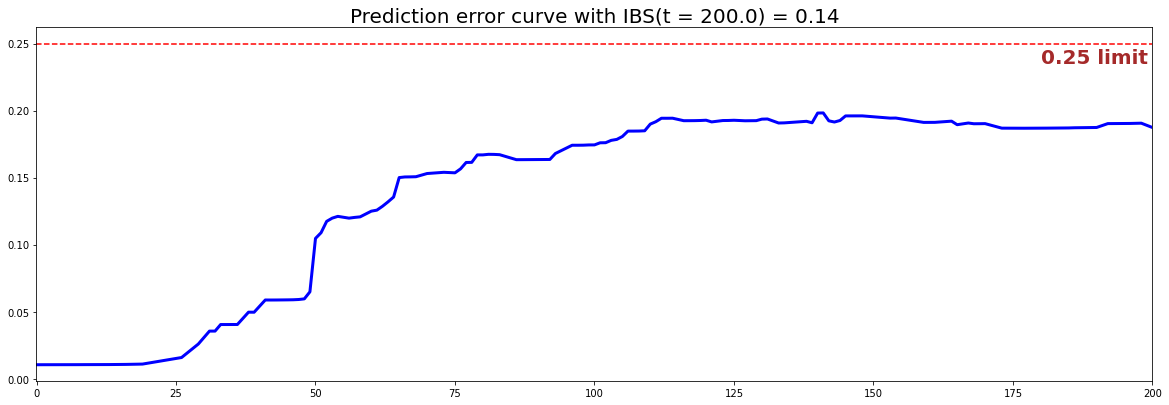

IBS: 0.1399
AUC: 0.7768


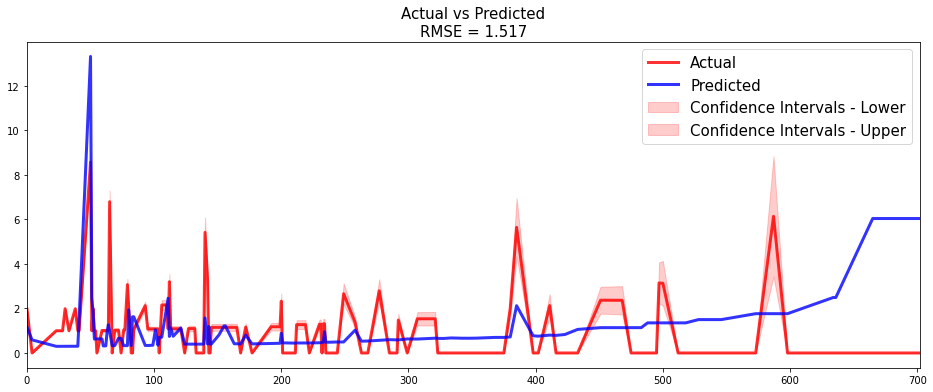

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


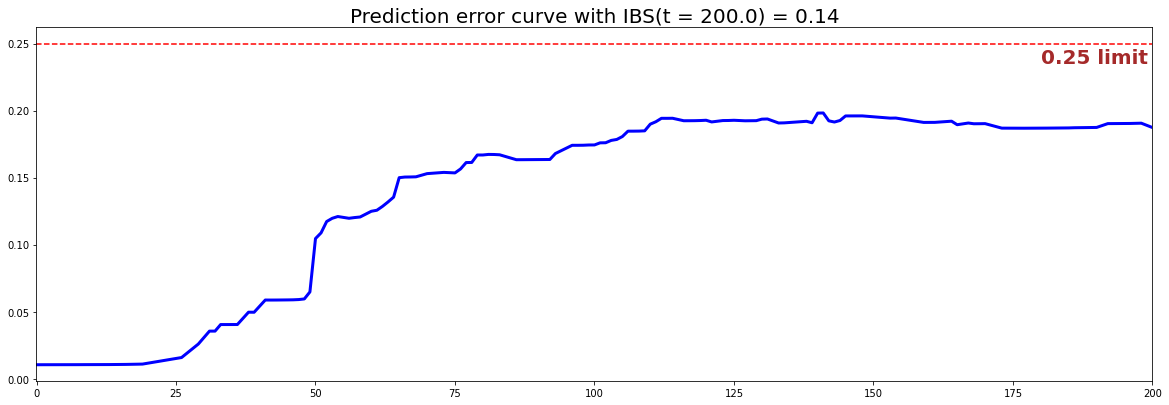

IBS: 0.1399
AUC: 0.7766


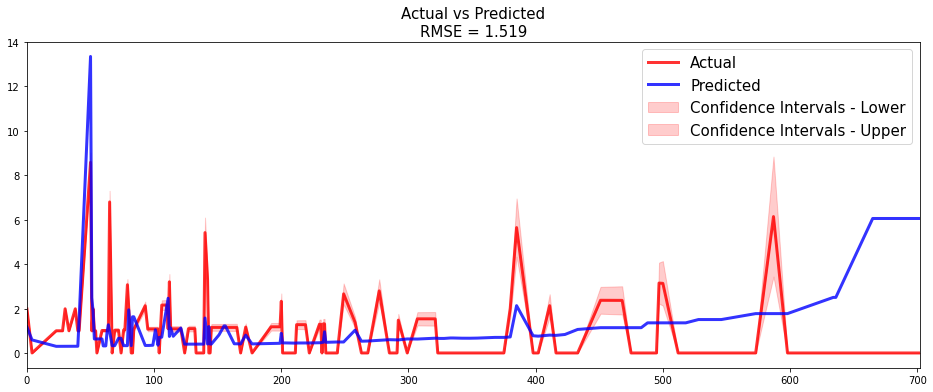

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


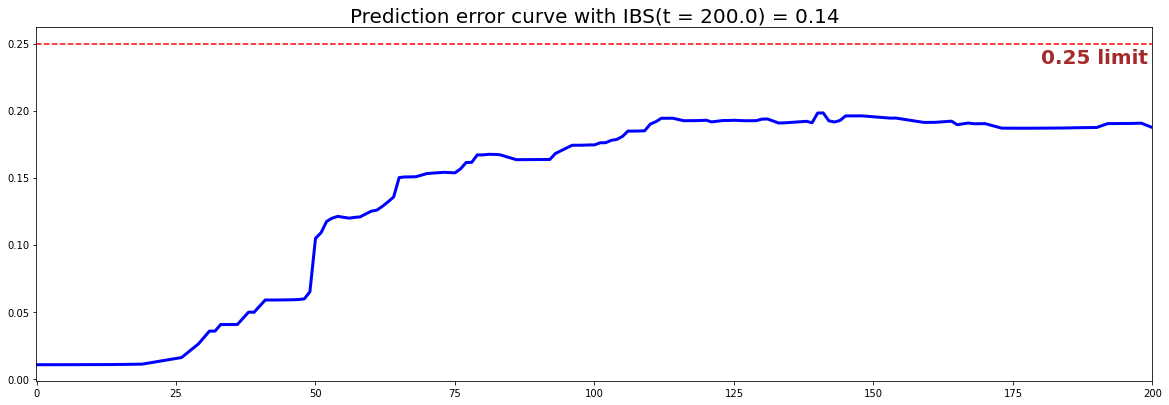

IBS: 0.1399
AUC: 0.7768


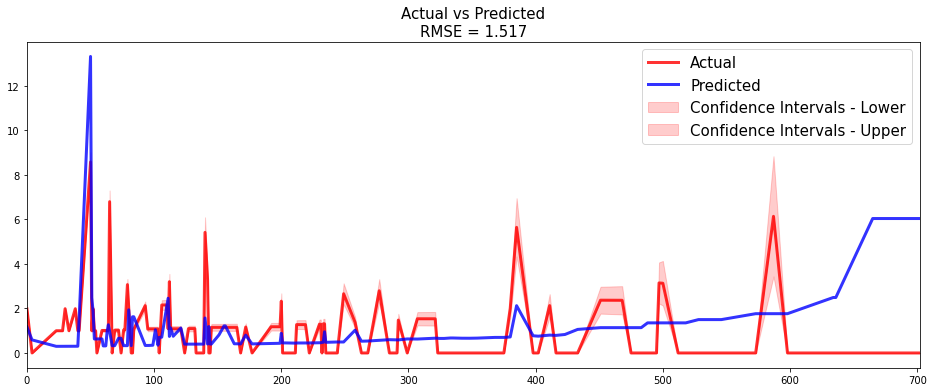

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


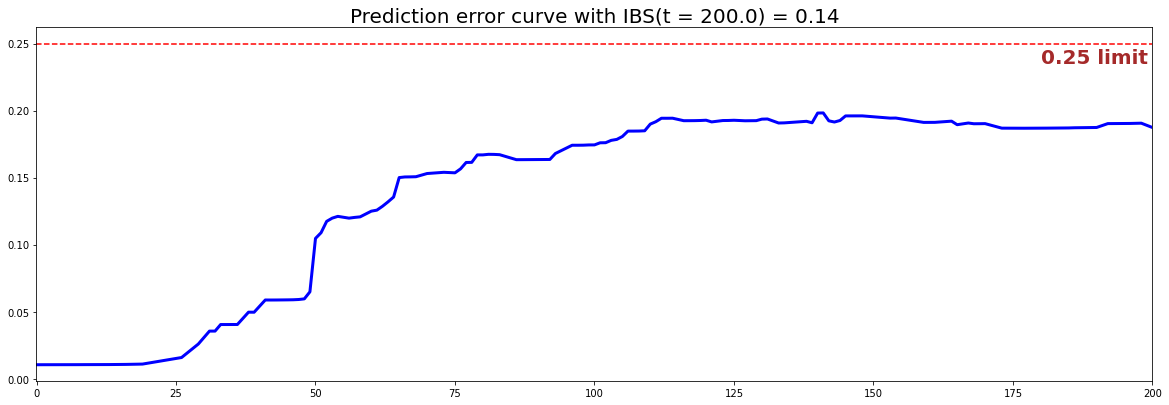

IBS: 0.1399
AUC: 0.7768


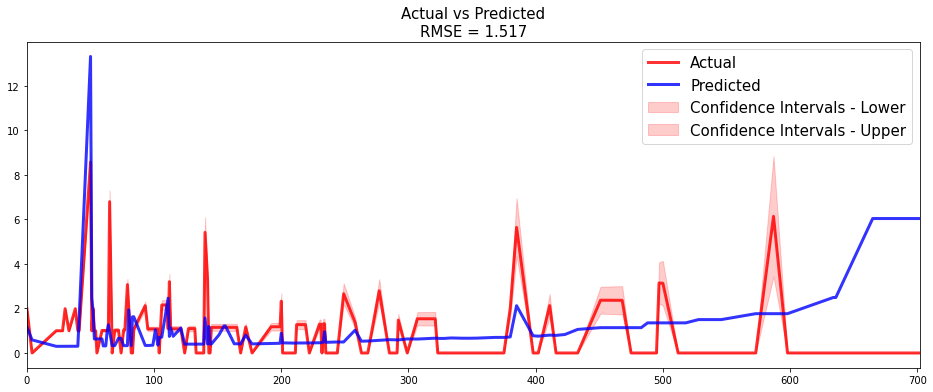

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.01 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


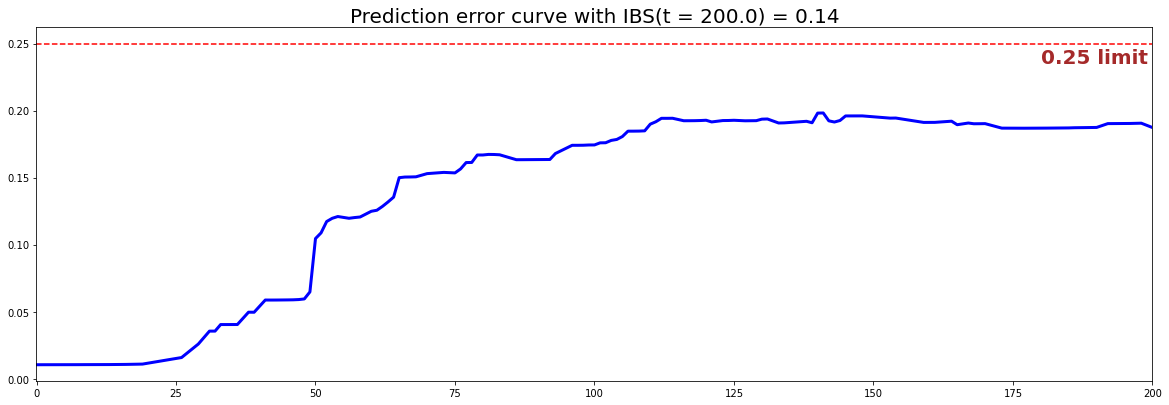

IBS: 0.1399
AUC: 0.7766


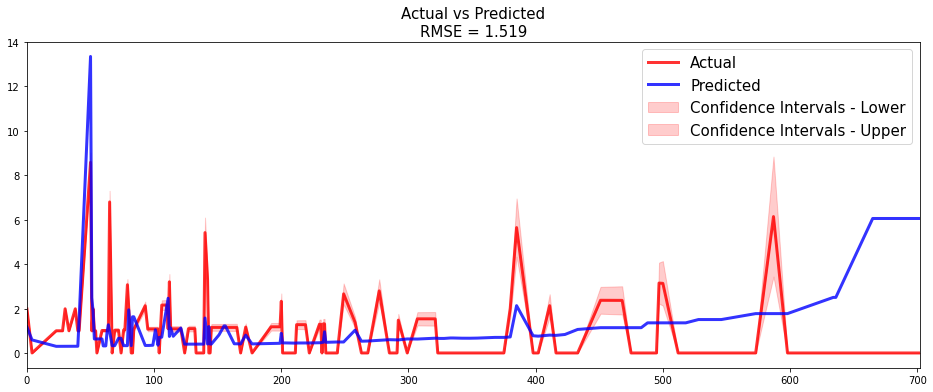

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.01 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


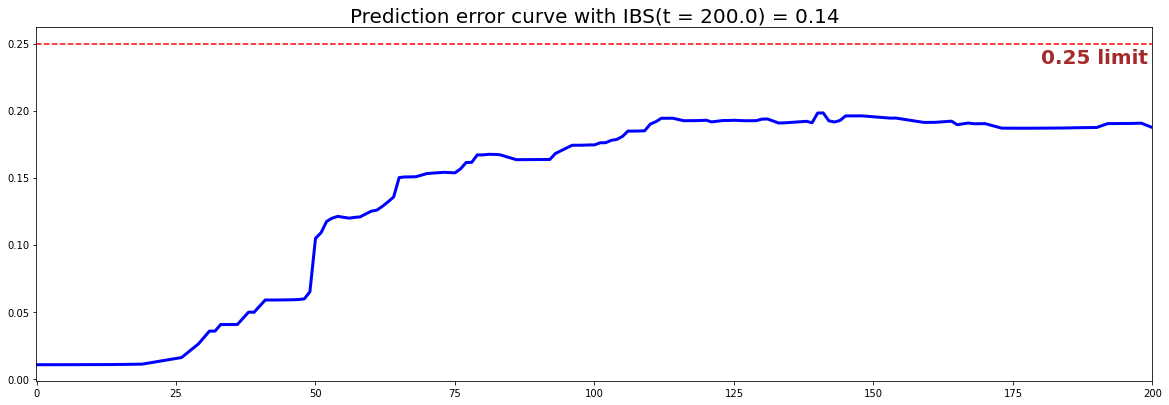

IBS: 0.1399
AUC: 0.7768


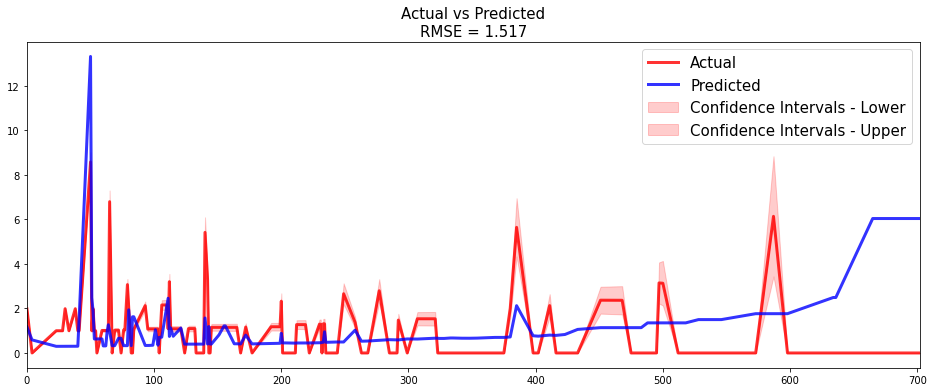

FIT MODEL WITH PARAMETERS
alpha:0.7 - tol:0.01 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


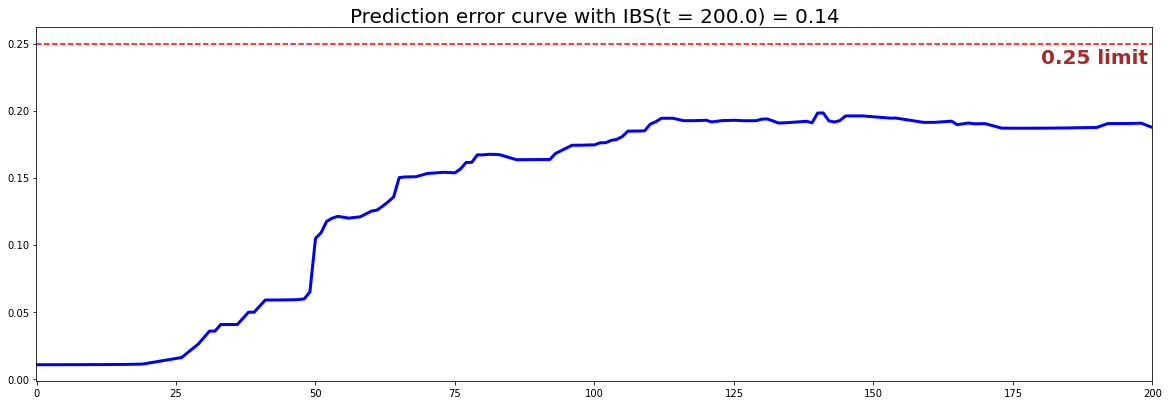

IBS: 0.1399
AUC: 0.7768


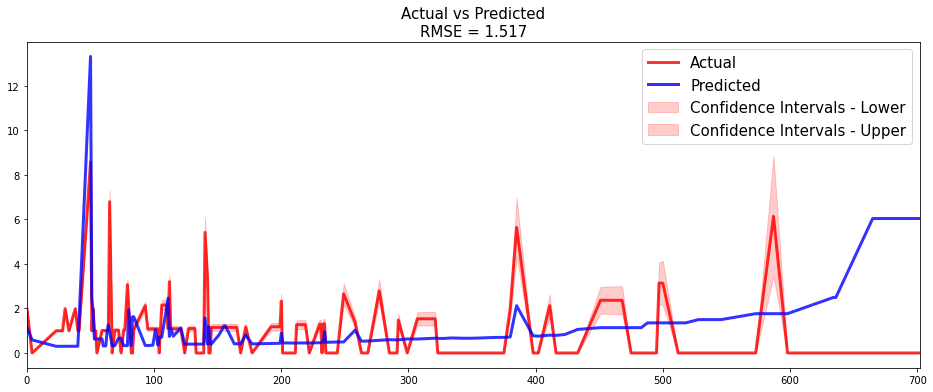

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.0001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


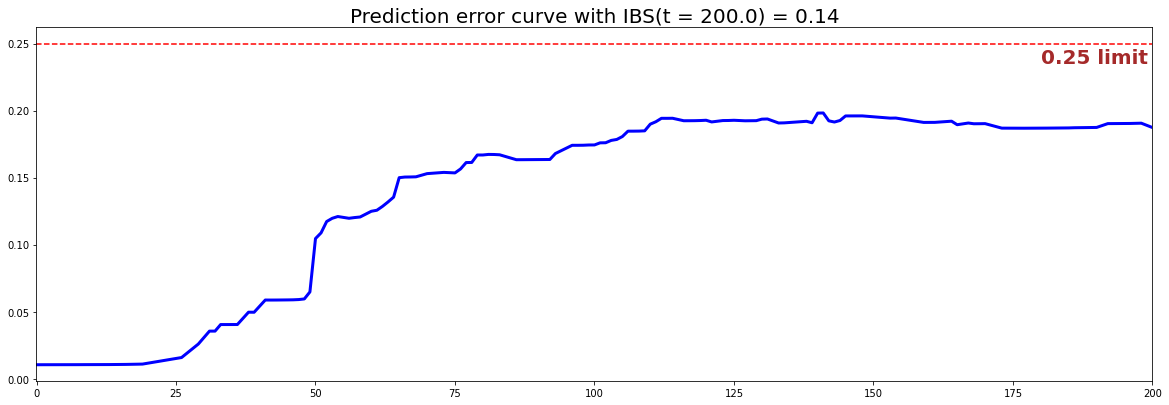

IBS: 0.1399
AUC: 0.7766


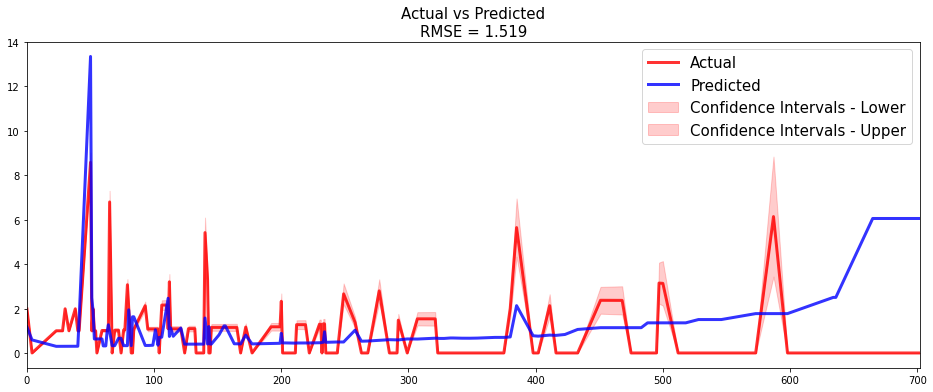

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.0001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


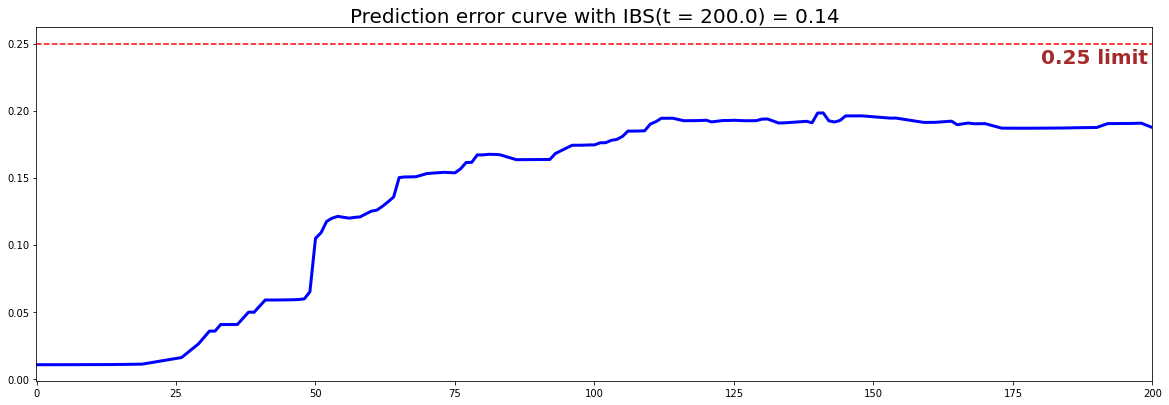

IBS: 0.1399
AUC: 0.7768


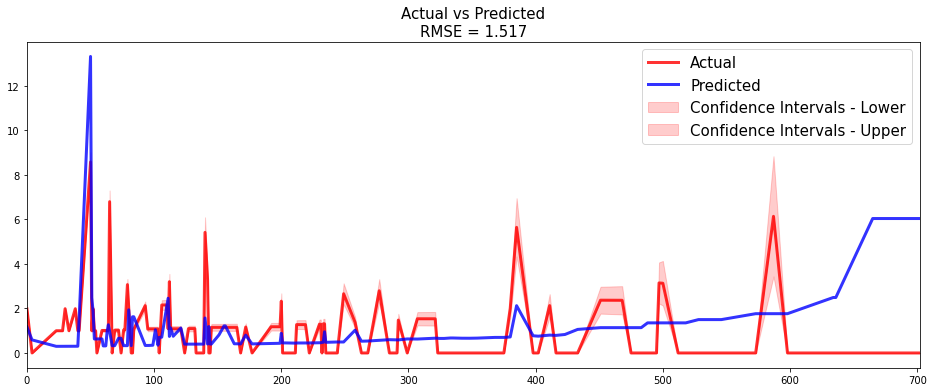

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.0001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


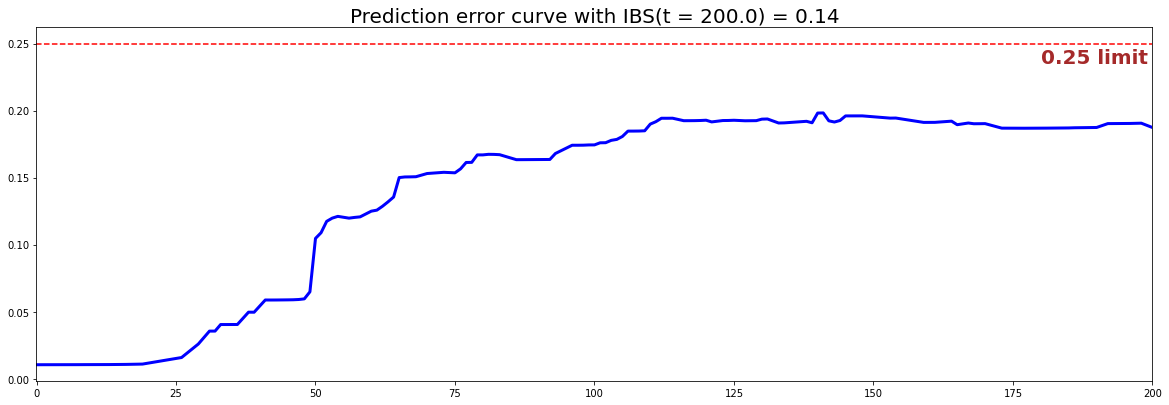

IBS: 0.1399
AUC: 0.7768


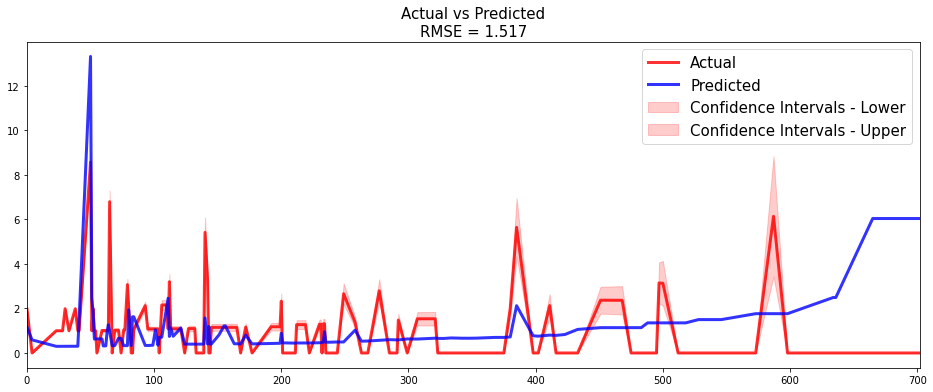

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


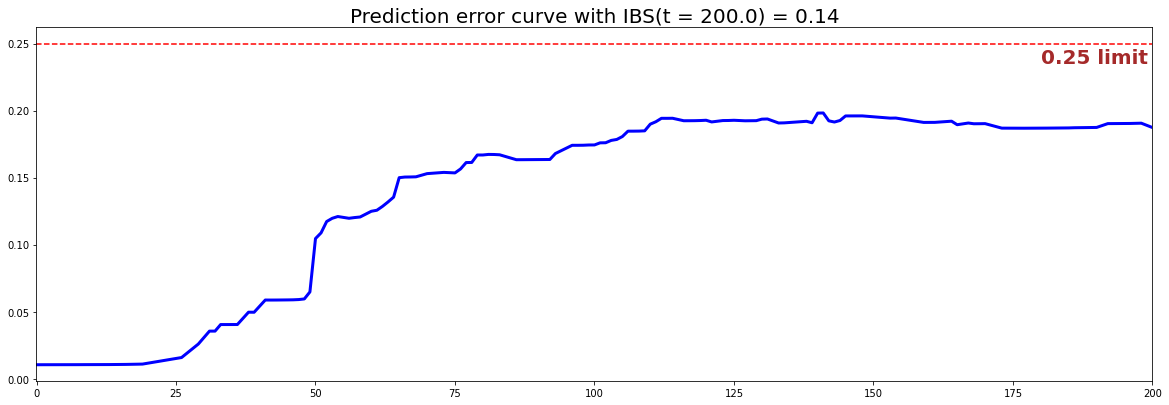

IBS: 0.1399
AUC: 0.7766


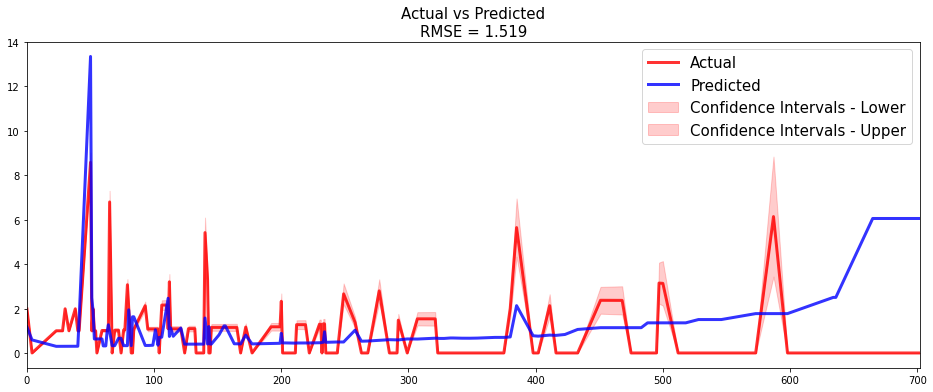

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


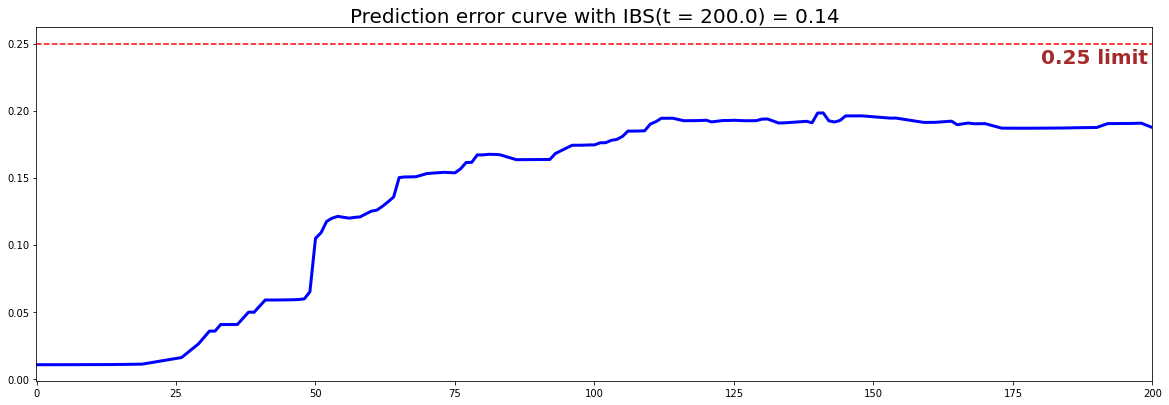

IBS: 0.1399
AUC: 0.7768


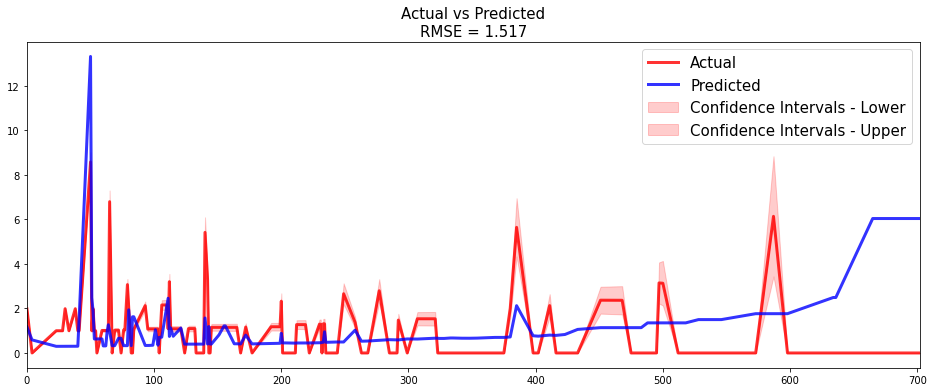

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


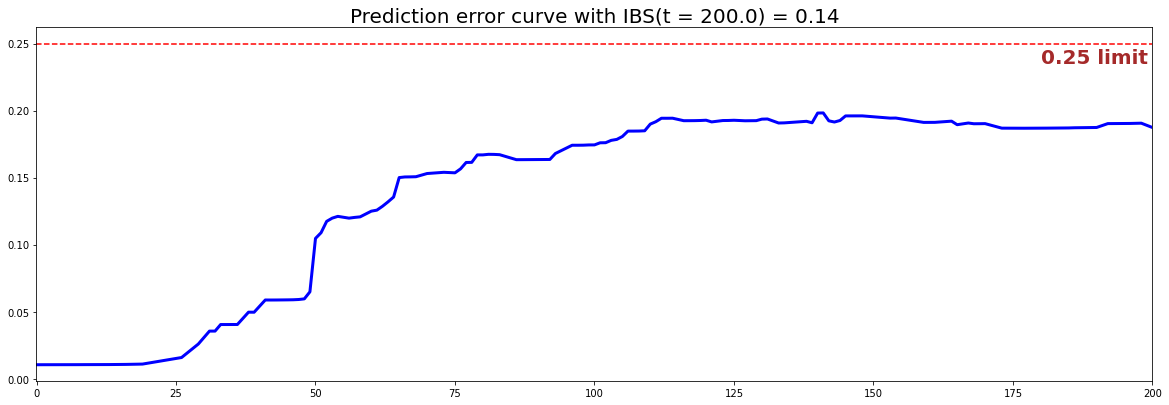

IBS: 0.1399
AUC: 0.7768


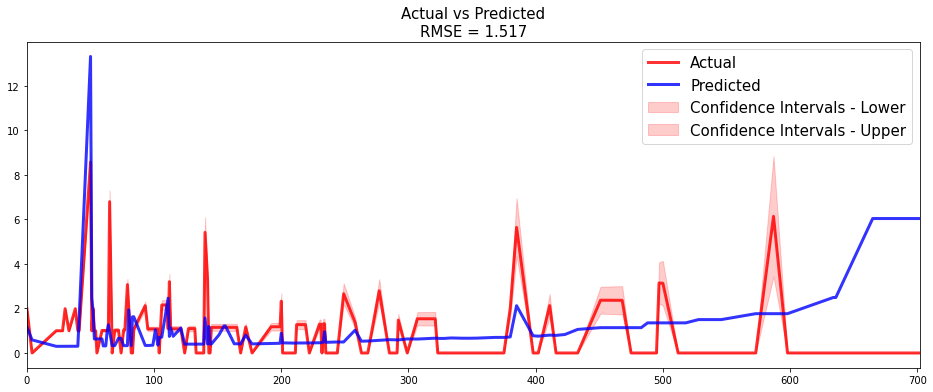

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.01 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


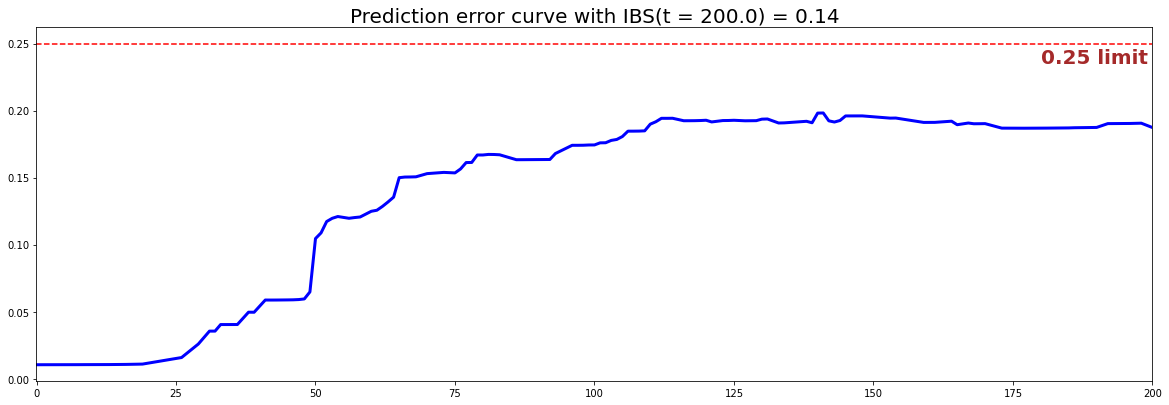

IBS: 0.1399
AUC: 0.7766


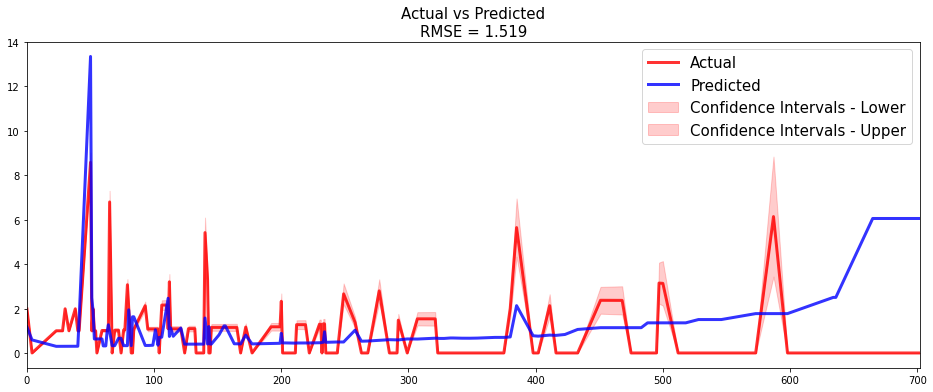

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.01 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


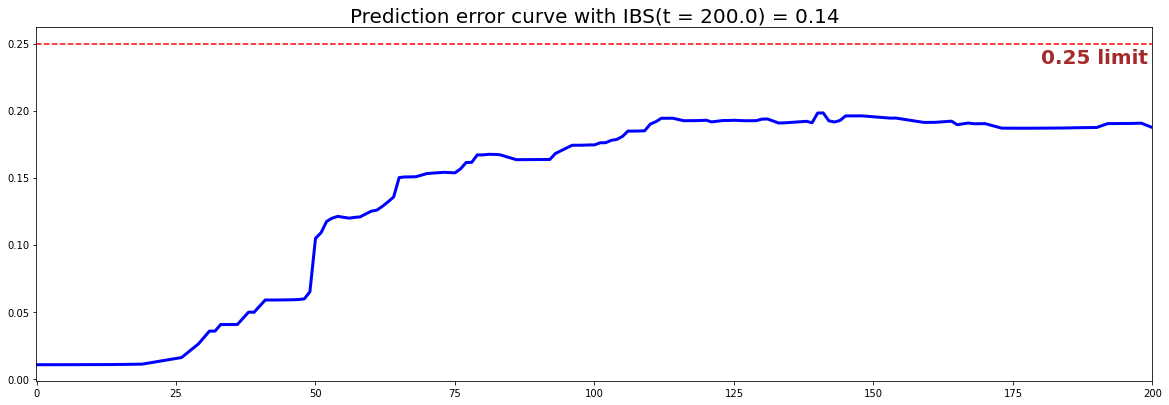

IBS: 0.1399
AUC: 0.7768


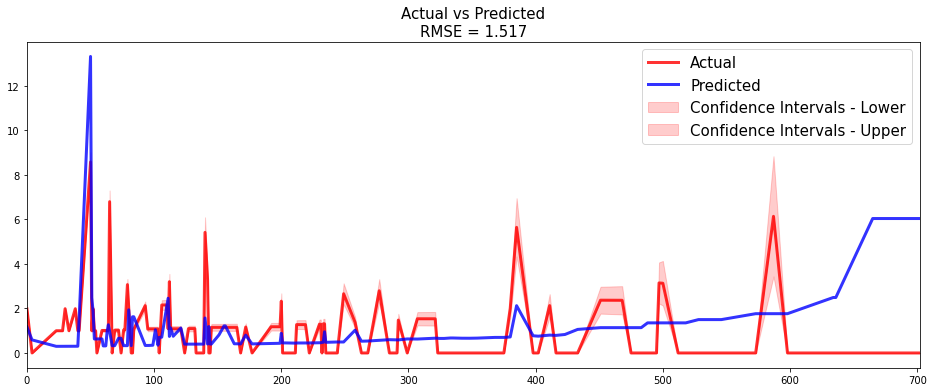

FIT MODEL WITH PARAMETERS
alpha:0.95 - tol:0.01 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


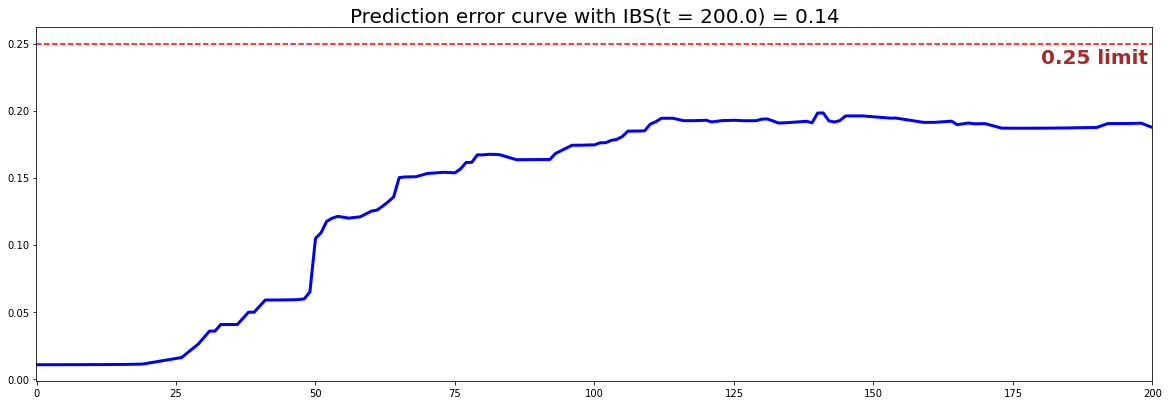

IBS: 0.1399
AUC: 0.7768


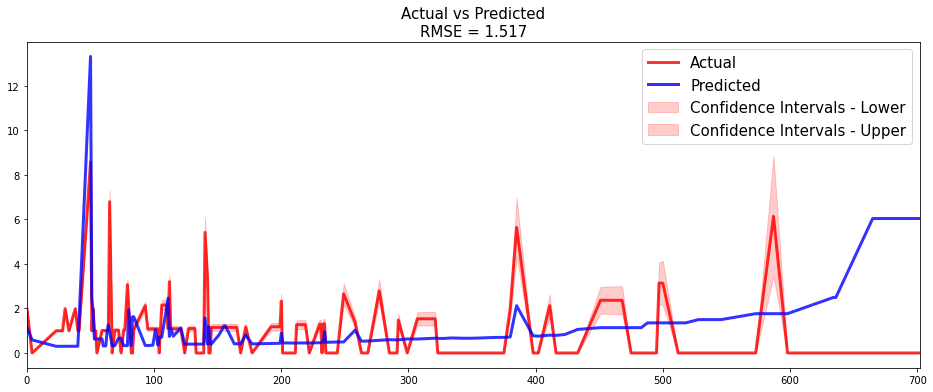

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.0001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


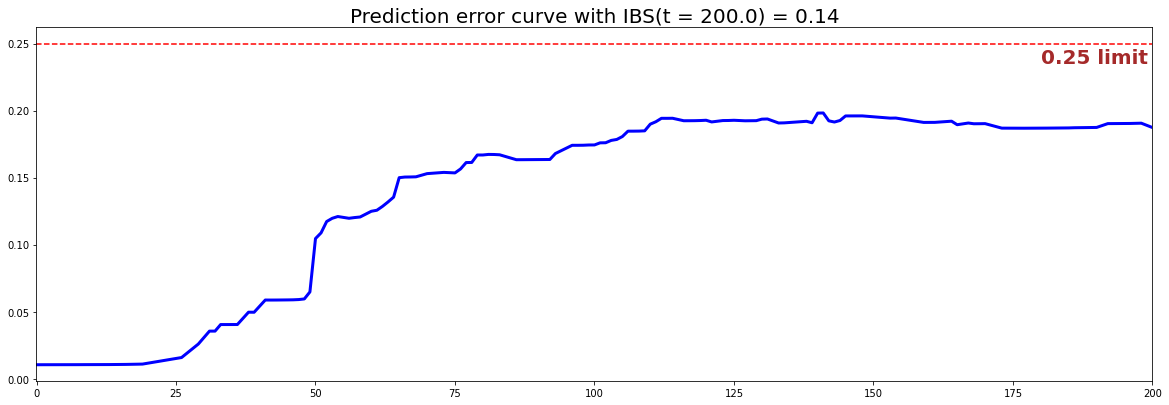

IBS: 0.1399
AUC: 0.7766


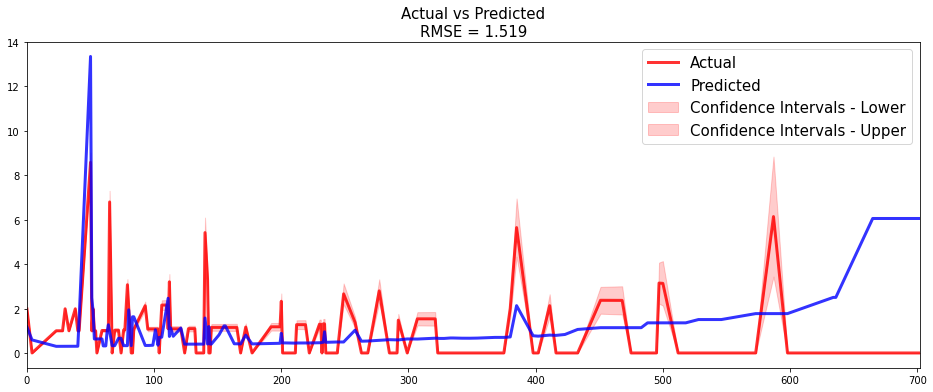

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.0001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


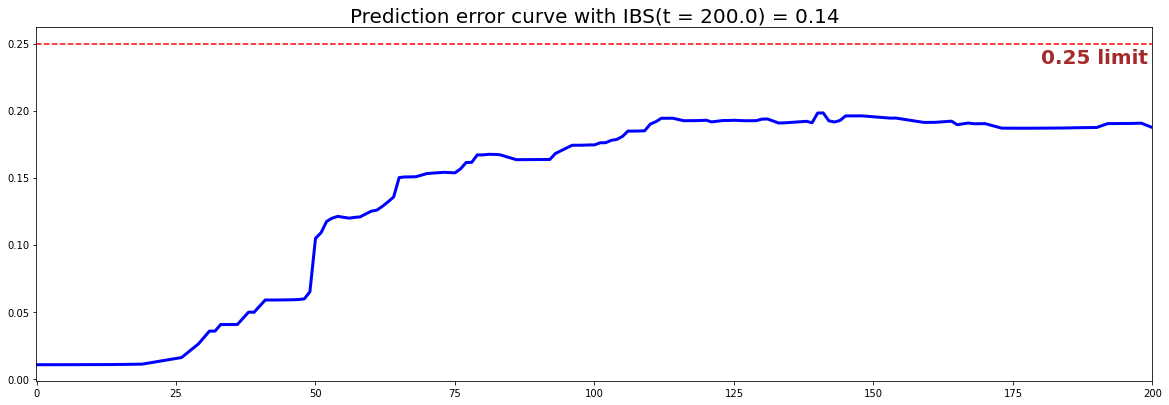

IBS: 0.1399
AUC: 0.7768


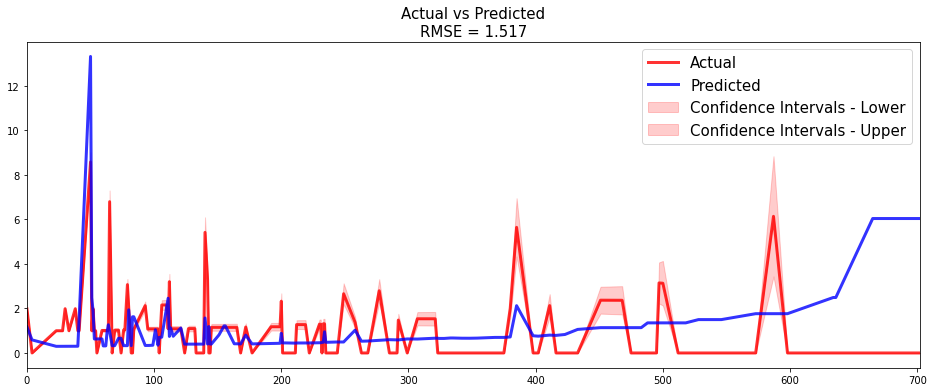

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.0001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


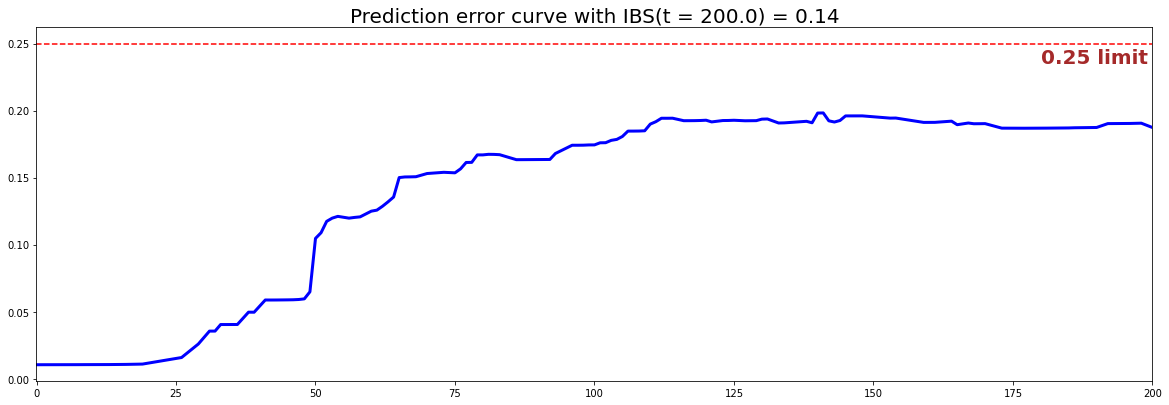

IBS: 0.1399
AUC: 0.7768


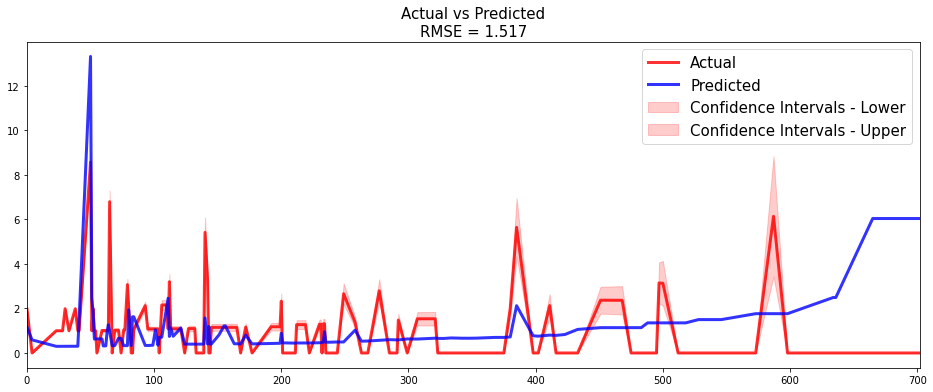

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.001 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


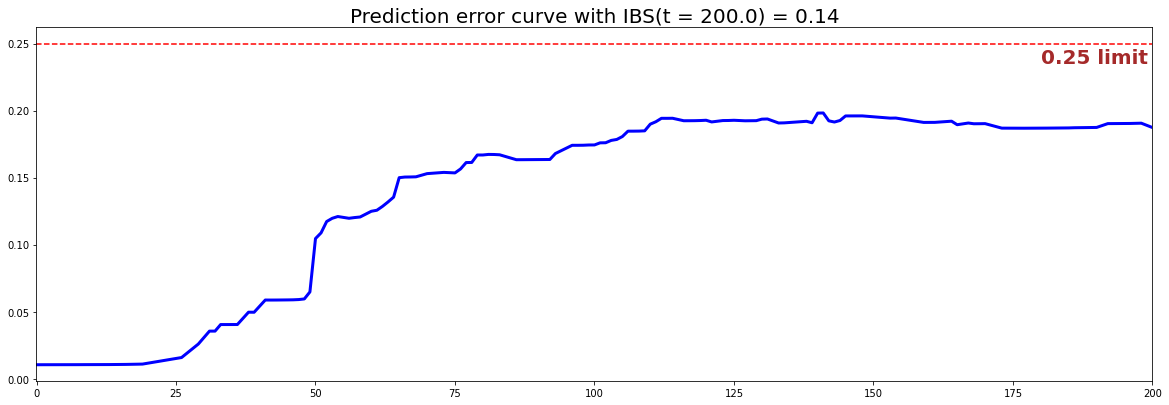

IBS: 0.1399
AUC: 0.7766


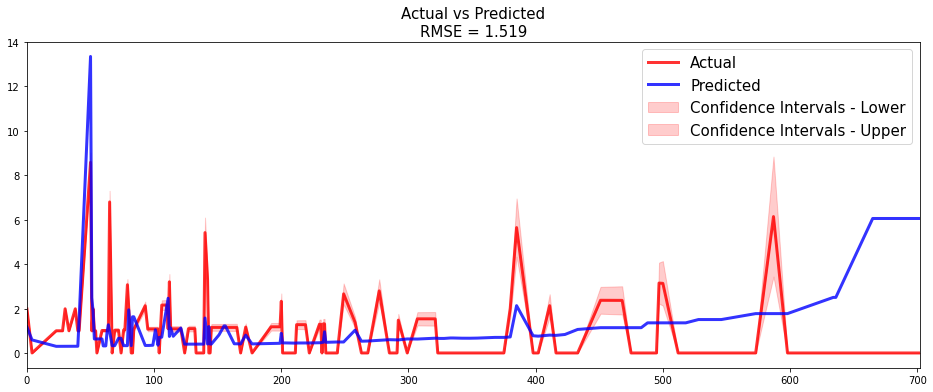

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.001 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


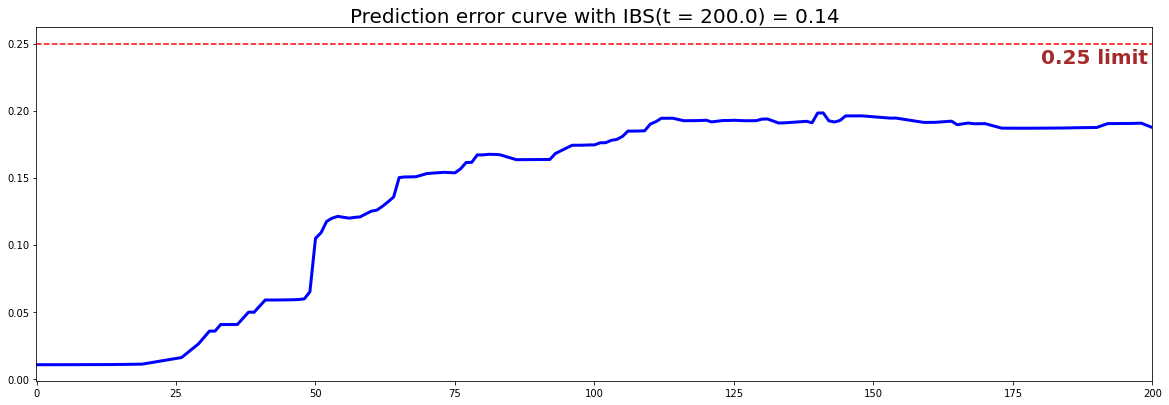

IBS: 0.1399
AUC: 0.7768


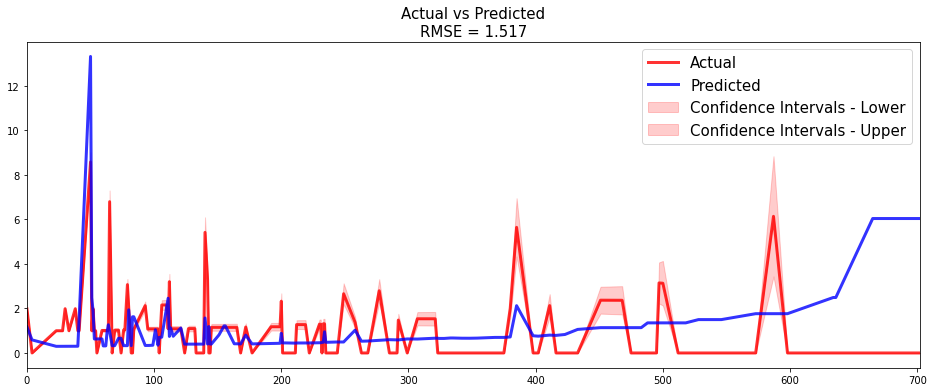

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.001 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


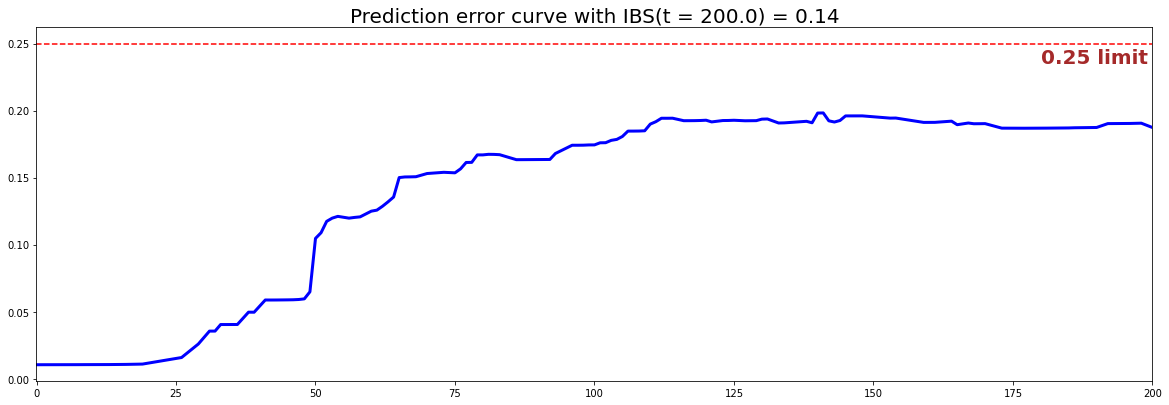

IBS: 0.1399
AUC: 0.7768


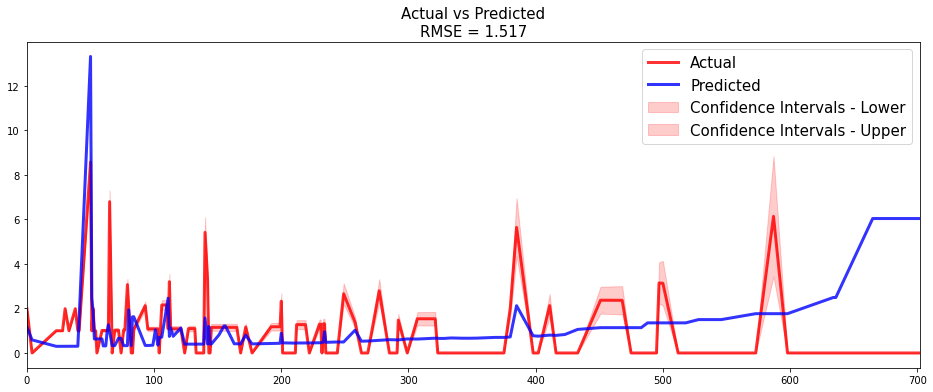

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.01 - max_iter:50


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7009


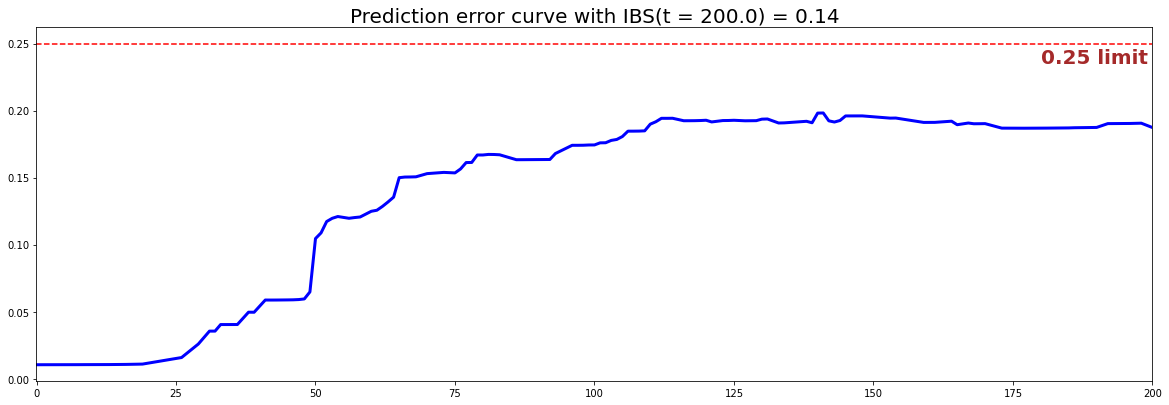

IBS: 0.1399
AUC: 0.7766


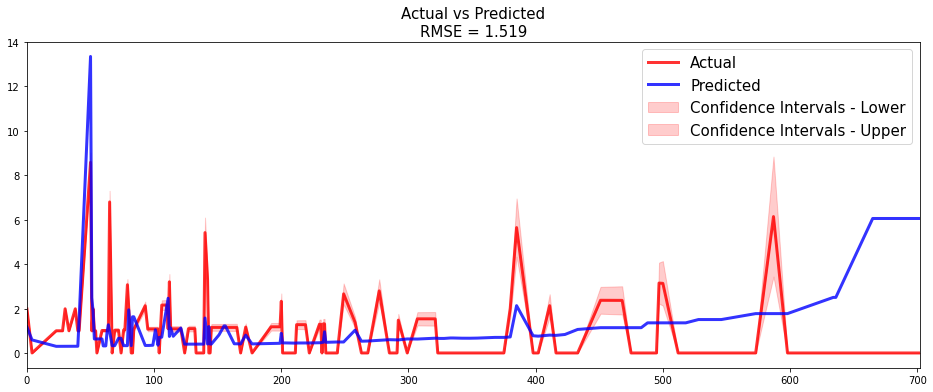

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.01 - max_iter:100


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


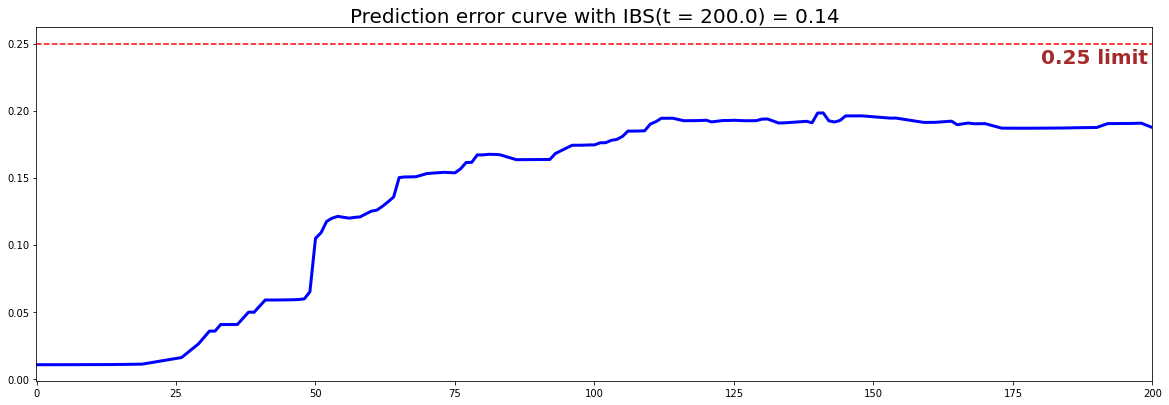

IBS: 0.1399
AUC: 0.7768


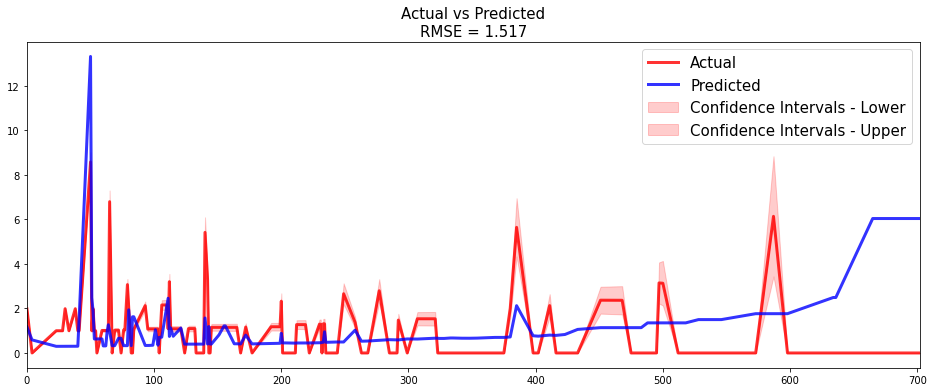

FIT MODEL WITH PARAMETERS
alpha:0.99 - tol:0.01 - max_iter:200


/usr/local/lib/python3.6/dist-packages/pysurvival/models/semi_parametric.py:49: RuntimeWarning: divide by zero encountered in true_divide
  self.std_err  = np.sqrt(self.inv_Hessian.diagonal())/self.std_scale


c-index: 0.7010


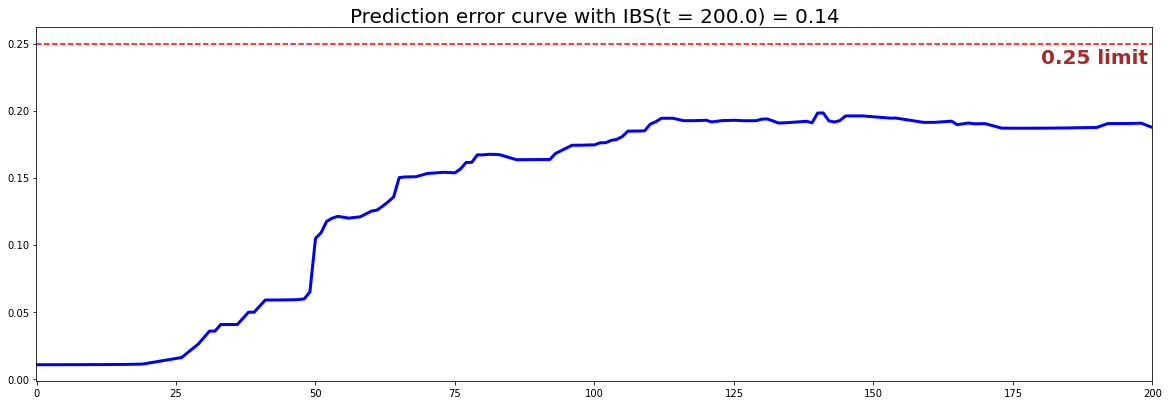

IBS: 0.1399
AUC: 0.7768


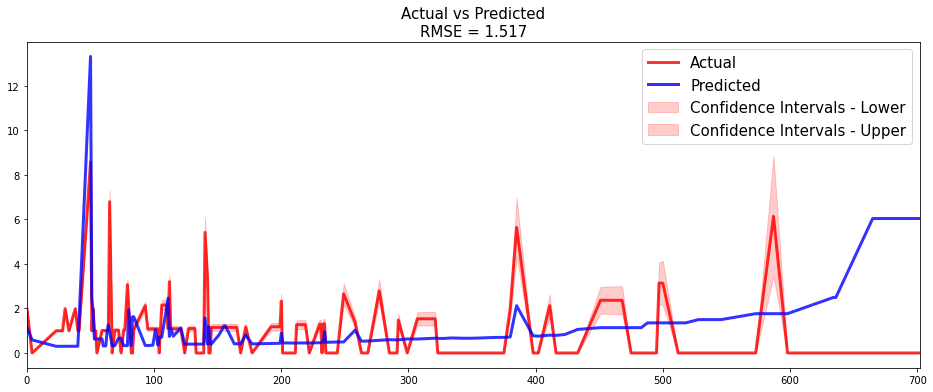

In [ ]:
from pysurvival.models.semi_parametric import CoxPHModel
import pandas as pd
import numpy as np

# Create empty dataframe for storing the results
results_coxph = pd.DataFrame()


for alpha in [0.7,0.95,0.99]:
  for tol in [1e-4,1e-3,1e-2]:
    for max_iter in [50,100,200]:

      print('FIT MODEL WITH PARAMETERS')
      print('alpha:{} - tol:{} - max_iter:{}'.format(alpha,tol,max_iter))

      # Creating an instance of the NonLinear CoxPH model and fitting the data.

      ### Defining the MLP structure. Here we will build a 1-hidden layer 
      ### with 150 units and `BentIdentity` as its activation function
      structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

      ## Build the model
      coxph = CoxPHModel()
      coxph.fit(X_train, T_train, E_train, lr=0.1, l2_reg=1e-2, init_method='zeros',verbose=False,
                max_iter=max_iter,alpha=alpha,tol=tol)

      ## Evaluate model
      tmp_results_coxph = evaluate_model(coxph,X_train,T_train,E_train,X_test,T_test,E_test)
      tmp_results_coxph['alpha'] = [alpha]
      tmp_results_coxph['tol'] = [tol]
      tmp_results_coxph['max_iter'] = [max_iter]        
      
      results_coxph = pd.concat([results_coxph, tmp_results_coxph], ignore_index=True)

In [ ]:
results_coxph.round(4).head(100)

c_index     ibs  mean_auc    rmse  alpha     tol  max_iter
0    0.7009  0.1399    0.7766  1.5188   0.70  0.0001        50
1    0.7010  0.1399    0.7768  1.5173   0.70  0.0001       100
2    0.7010  0.1399    0.7768  1.5172   0.70  0.0001       200
3    0.7009  0.1399    0.7766  1.5188   0.70  0.0010        50
4    0.7010  0.1399    0.7768  1.5173   0.70  0.0010       100
5    0.7010  0.1399    0.7768  1.5172   0.70  0.0010       200
6    0.7009  0.1399    0.7766  1.5188   0.70  0.0100        50
7    0.7010  0.1399    0.7768  1.5173   0.70  0.0100       100
8    0.7010  0.1399    0.7768  1.5172   0.70  0.0100       200
9    0.7009  0.1399    0.7766  1.5188   0.95  0.0001        50
10   0.7010  0.1399    0.7768  1.5173   0.95  0.0001       100
11   0.7010  0.1399    0.7768  1.5172   0.95  0.0001       200
12   0.7009  0.1399    0.7766  1.5188   0.95  0.0010        50
13   0.7010  0.1399    0.7768  1.5173   0.95  0.0010       100
14   0.7010  0.1399    0.7768  1.5172   0.95  0.0010       200
15   0.7009  0.1399    0.7766  1.5188   0.95  0.0100        50
16   0.7010  0.1399    0.7768  1.5173   0.95  0.0100       100
17   0.7010  0.1399    0.7768  1.5172   0.95  0.0100       200
18   0.7009  0.1399    0.7766  1.5188   0.99  0.0001        50
19   0.7010  0.1399    0.7768  1.5173   0.99  0.0001       100
20   0.7010  0.1399    0.7768  1.5172   0.99  0.0001       200
21   0.7009  0.1399    0.7766  1.5188   0.99  0.0010        50
22   0.7010  0.1399    0.7768  1.5173   0.99  0.0010       100
23   0.7010  0.1399    0.7768  1.5172   0.99  0.0010       200
24   0.7009  0.1399    0.7766  1.5188   0.99  0.0100        50
25   0.7010  0.1399    0.7768  1.5173   0.99  0.0100       100
26   0.7010  0.1399    0.7768  1.5172   0.99  0.0100       200

In [ ]:
print('max c_index is on line:{}'.format(results_coxph['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results_coxph['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results_coxph['ibs'].idxmin()))
print('min rmse is on line:{}'.format(results_coxph['rmse'].idxmin()))

max c_index is on line:1
max mean_auc is on line:1
min ibs is on line:0
min rmse is on line:2


## Model Optimizacion: DeepSurv/Non-Linear CoxPH model

FIT MODEL WITH PARAMETERS
num_epochs:500 - dropout:0.1


c-index: 0.7010


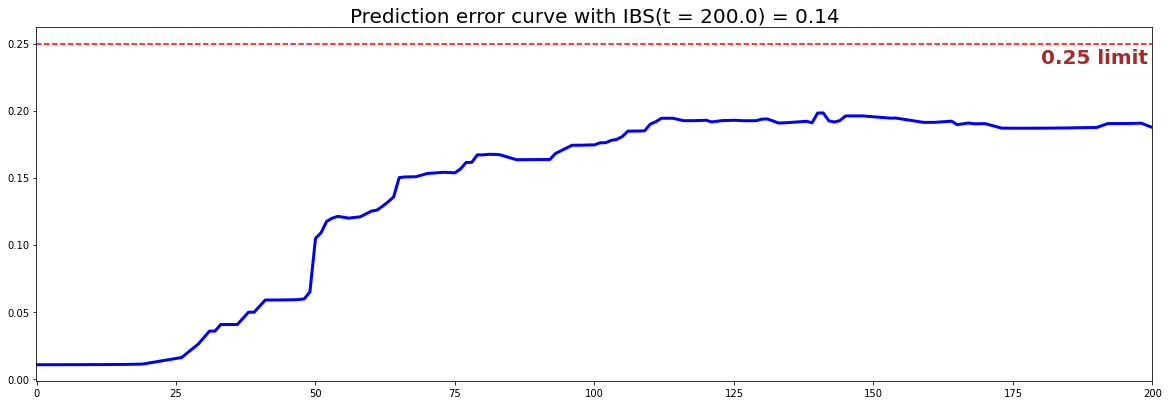

IBS: 0.1399
AUC: 0.7768


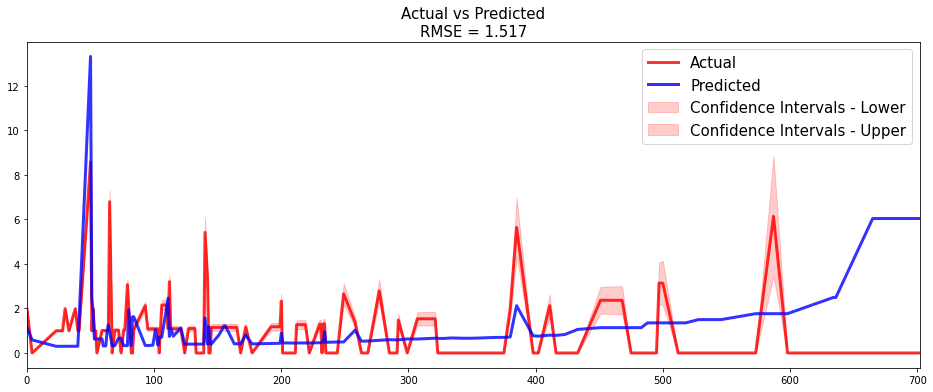

FIT MODEL WITH PARAMETERS
num_epochs:500 - dropout:0.3


c-index: 0.7010


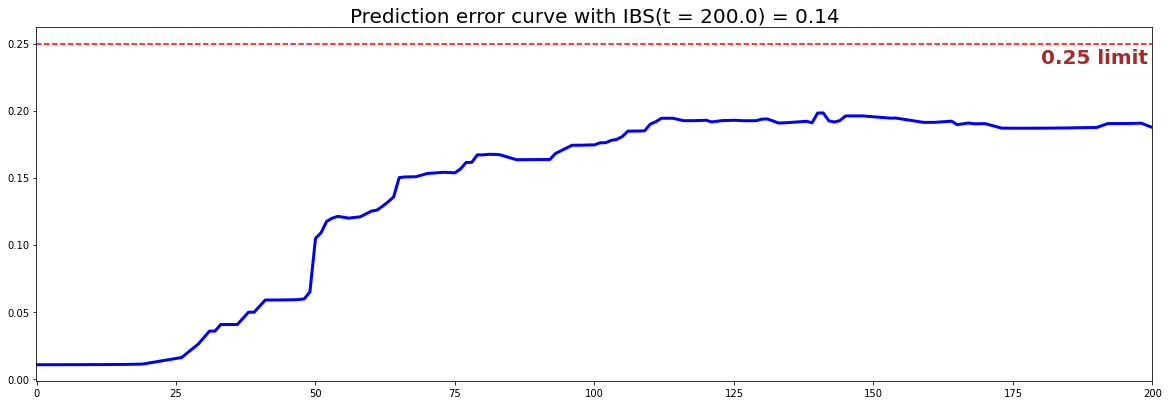

IBS: 0.1399
AUC: 0.7768


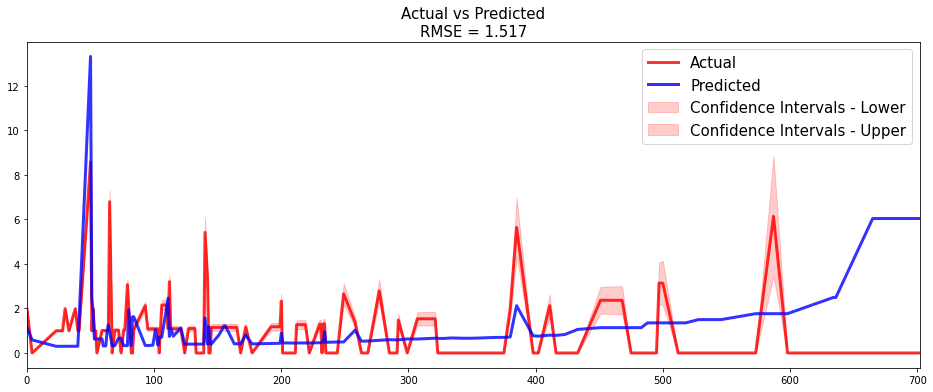

FIT MODEL WITH PARAMETERS
num_epochs:500 - dropout:0.5


c-index: 0.7010


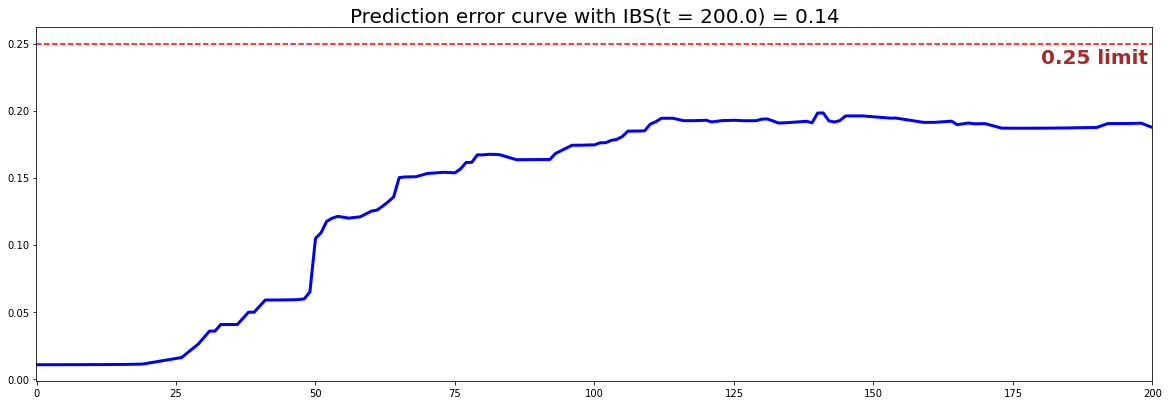

IBS: 0.1399
AUC: 0.7768


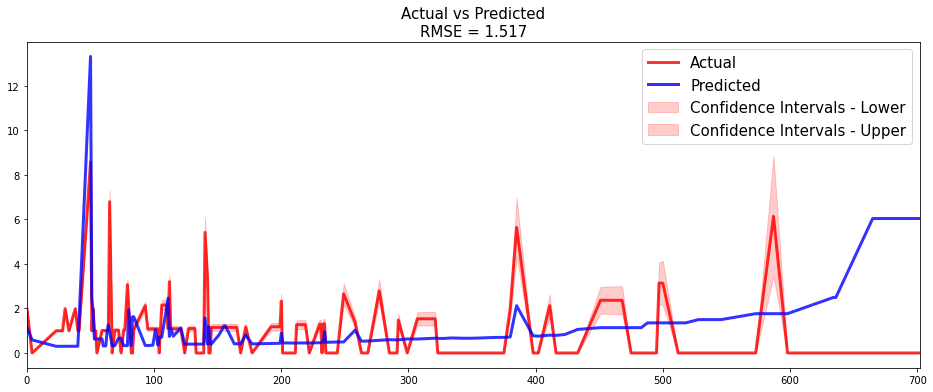

FIT MODEL WITH PARAMETERS
num_epochs:1000 - dropout:0.1


c-index: 0.7010


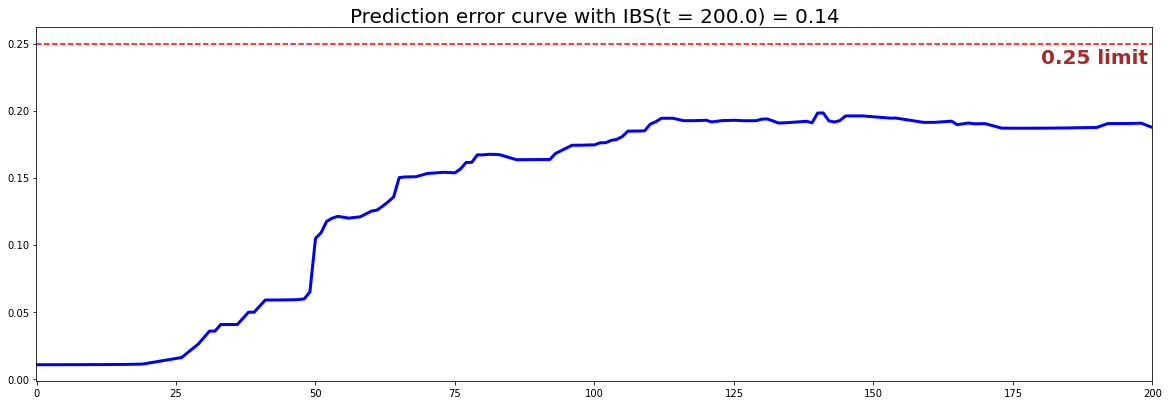

IBS: 0.1399
AUC: 0.7768


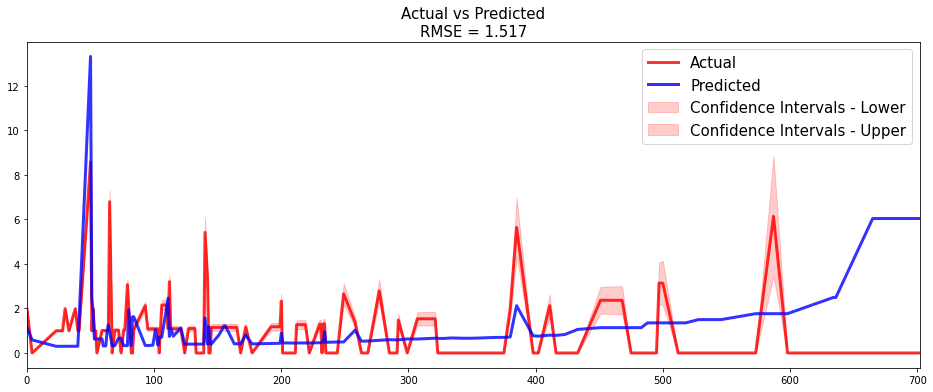

FIT MODEL WITH PARAMETERS
num_epochs:1000 - dropout:0.3


c-index: 0.7010


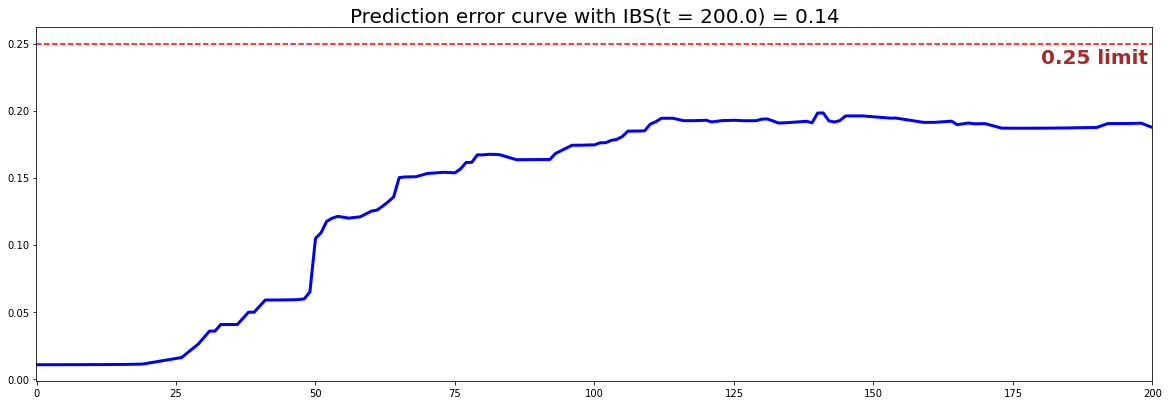

IBS: 0.1399
AUC: 0.7768


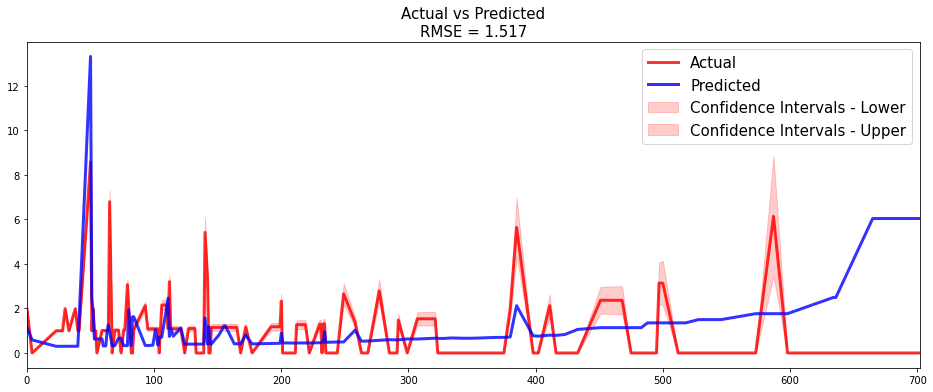

FIT MODEL WITH PARAMETERS
num_epochs:1000 - dropout:0.5


c-index: 0.7010


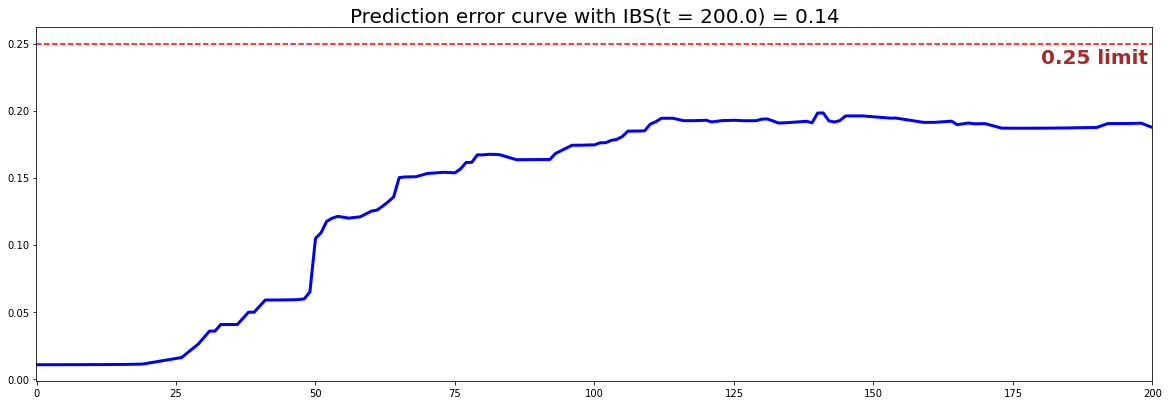

IBS: 0.1399
AUC: 0.7768


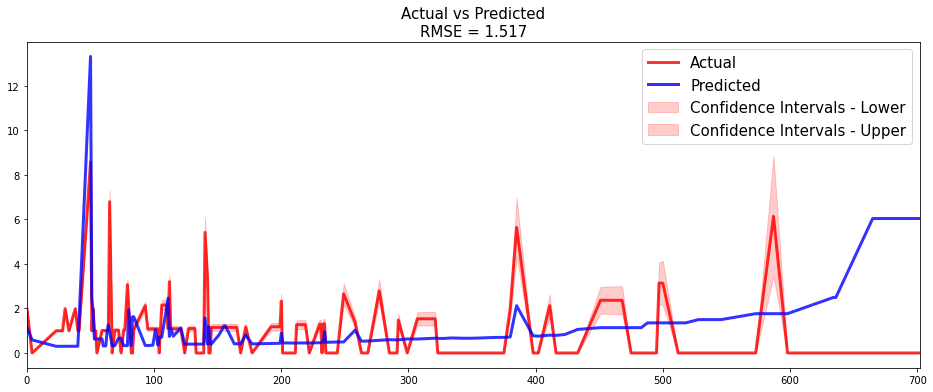

FIT MODEL WITH PARAMETERS
num_epochs:2000 - dropout:0.1


c-index: 0.7010


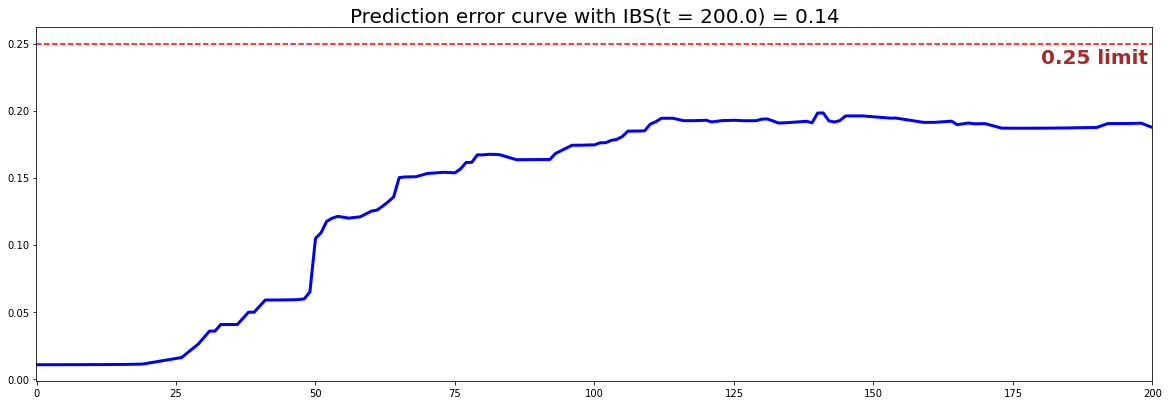

IBS: 0.1399
AUC: 0.7768


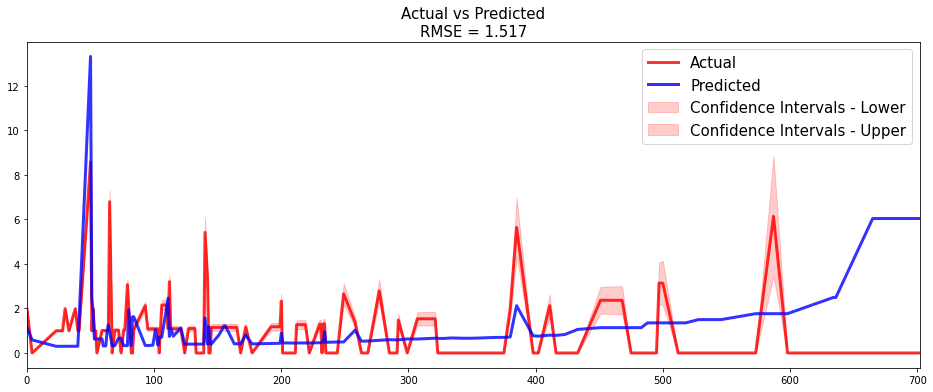

FIT MODEL WITH PARAMETERS
num_epochs:2000 - dropout:0.3


c-index: 0.7010


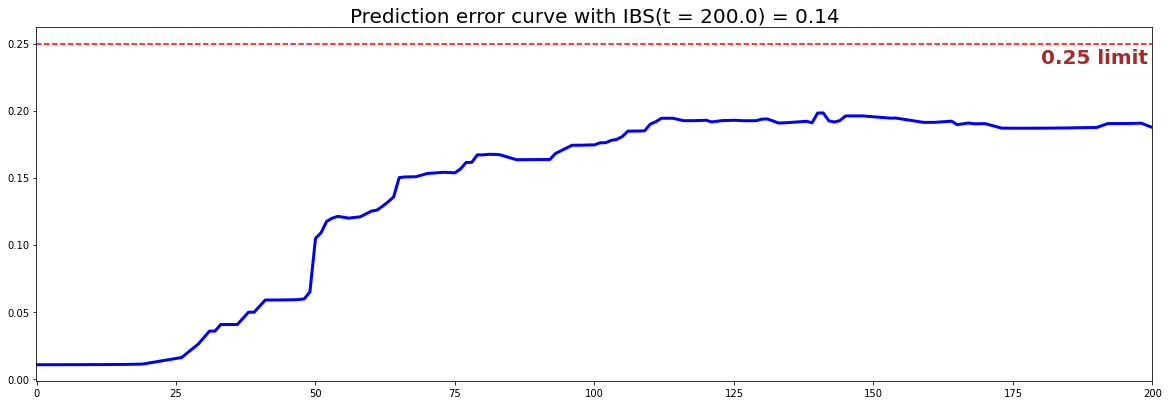

IBS: 0.1399
AUC: 0.7768


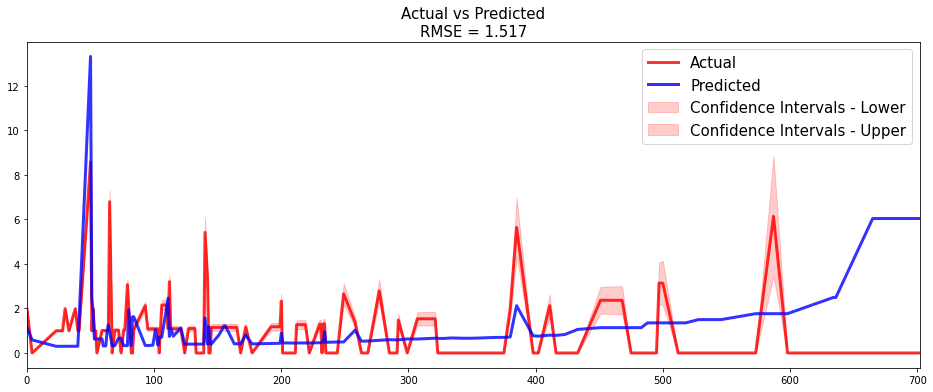

FIT MODEL WITH PARAMETERS
num_epochs:2000 - dropout:0.5


c-index: 0.7010


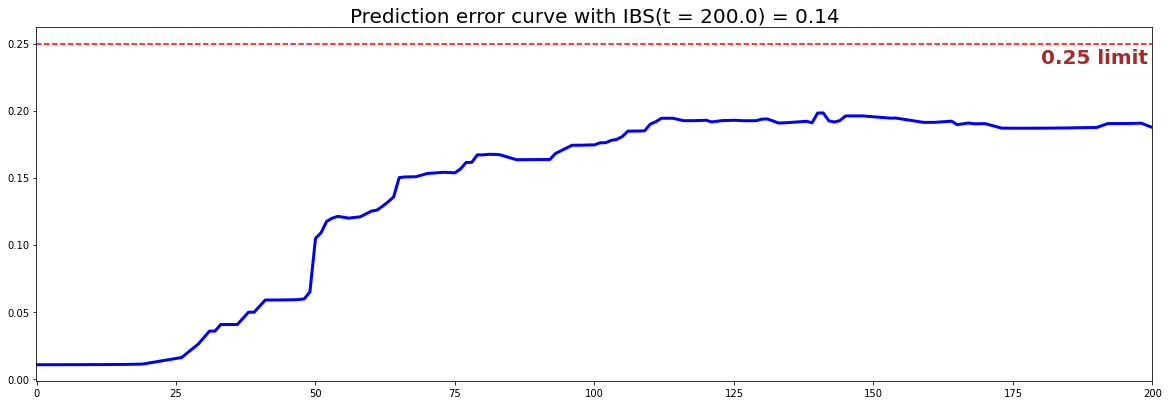

IBS: 0.1399
AUC: 0.7768


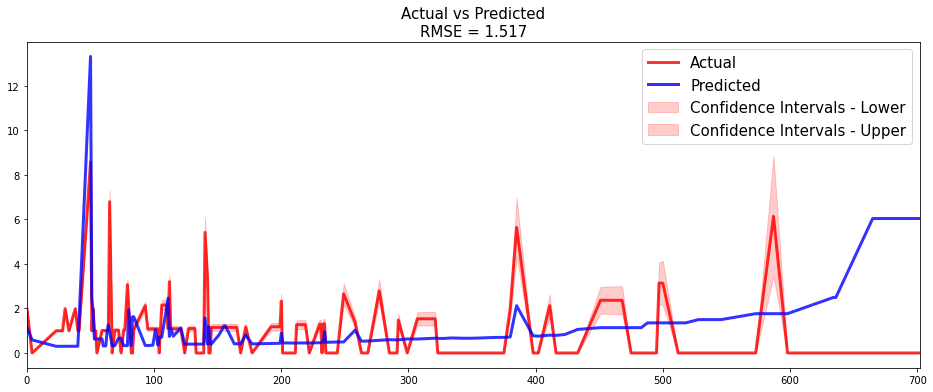

In [ ]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
import pandas as pd
import numpy as np

# Create empty dataframe for storing the results
results_nl_coxph = pd.DataFrame()

# Test num_trees

for num_epochs in [500,1000,2000]:
  for dropout in [0.1,0.3,0.5]:

    print('FIT MODEL WITH PARAMETERS')
    print('num_epochs:{} - dropout:{}'.format(num_epochs, dropout))

    # Creating an instance of the NonLinear CoxPH model and fitting the data.

    ### Defining the MLP structure. Here we will build a 1-hidden layer 
    ### with 150 units and `BentIdentity` as its activation function
    structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

    ## Build the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, T_train, E_train, init_method='xav_uniform', lr=1e-3,
                        num_epochs = num_epochs, dropout = dropout)

    ## Evaluate model
    tmp_results_nl_coxph = evaluate_model(coxph,X_train,T_train,E_train,X_test,T_test,E_test)
    tmp_results_nl_coxph['num_epochs'] = [num_epochs]
    tmp_results_nl_coxph['dropout'] = [dropout]        
    
    results_nl_coxph = pd.concat([results_nl_coxph, tmp_results_nl_coxph], ignore_index=True)

In [ ]:
results_nl_coxph.round(4).head(100)

c_index     ibs  mean_auc    rmse  num_epochs  dropout
0    0.701  0.1399    0.7768  1.5172         500      0.1
1    0.701  0.1399    0.7768  1.5172         500      0.3
2    0.701  0.1399    0.7768  1.5172         500      0.5
3    0.701  0.1399    0.7768  1.5172        1000      0.1
4    0.701  0.1399    0.7768  1.5172        1000      0.3
5    0.701  0.1399    0.7768  1.5172        1000      0.5
6    0.701  0.1399    0.7768  1.5172        2000      0.1
7    0.701  0.1399    0.7768  1.5172        2000      0.3
8    0.701  0.1399    0.7768  1.5172        2000      0.5

In [ ]:
print('max c_index is on line:{}'.format(results_nl_coxph['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results_nl_coxph['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results_nl_coxph['ibs'].idxmin()))
print('min rmse is on line:{}'.format(results_nl_coxph['rmse'].idxmin()))

max c_index is on line:0
max mean_auc is on line:0
min ibs is on line:0
min rmse is on line:0


# Compare results

In [ ]:
import pandas as pd

best_results_rsf = results_rsf.drop(['num_trees','max_depth','min_node_size'],axis=1)
best_results_rsf['model'] = 'Random Survival Forest'

best_results_coxph = results_coxph.drop(['alpha','tol','max_iter'],axis=1)
best_results_coxph['model'] = 'Cox Proportional Hazard'

best_results_nl_coxph = results_nl_coxph.drop(['num_epochs','dropout'],axis=1)
best_results_nl_coxph['model'] = 'Non-Linear Cox Proportional Hazard'

results_compare = pd.concat([best_results_rsf,best_results_coxph,best_results_nl_coxph], ignore_index=True)
results_compare.round(4)

c_index     ibs  mean_auc    rmse                               model
0    0.6954  0.1382    0.7702  1.4112              Random Survival Forest
1    0.7033  0.1353    0.7784  1.3582              Random Survival Forest
2    0.6806  0.1400    0.7482  1.3584              Random Survival Forest
3    0.6900  0.1354    0.7648  1.3770              Random Survival Forest
4    0.6948  0.1346    0.7756  1.3513              Random Survival Forest
..      ...     ...       ...     ...                                 ...
58   0.7010  0.1399    0.7768  1.5172  Non-Linear Cox Proportional Hazard
59   0.7010  0.1399    0.7768  1.5172  Non-Linear Cox Proportional Hazard
60   0.7010  0.1399    0.7768  1.5172  Non-Linear Cox Proportional Hazard
61   0.7010  0.1399    0.7768  1.5172  Non-Linear Cox Proportional Hazard
62   0.7010  0.1399    0.7768  1.5172  Non-Linear Cox Proportional Hazard

[63 rows x 5 columns]

In [ ]:
print('max c_index is on line:{}'.format(results_compare['c_index'].idxmax()))
print('max mean_auc is on line:{}'.format(results_compare['mean_auc'].idxmax()))
print('min ibs is on line:{}'.format(results_compare['ibs'].idxmin()))
print('min rmse is on line:{}'.format(results_compare['rmse'].idxmin()))

max c_index is on line:9
max mean_auc is on line:9
min ibs is on line:24
min rmse is on line:4


In [ ]:
best_results_rsf.iloc[[4,9,24],:].round(4)

c_index     ibs  mean_auc    rmse                   model
4    0.6948  0.1346    0.7756  1.3513  Random Survival Forest
9    0.7057  0.1351    0.7819  1.3654  Random Survival Forest
24   0.7005  0.1333    0.7802  1.3695  Random Survival Forest